In [8]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sns
import os
from cmapPy.pandasGEXpress.parse import parse
from utils.replicateCorrs import replicateCorrs
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile,saveDF_to_CSV_GZ_no_timestamp
from importlib import reload
from utils.normalize_funcs import standardize_per_catX
# sns.set_style("whitegrid")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# np.__version__
pd.__version__

'1.1.1'

###  Cell Painting morphological (CP) and L1000 gene expression (GE) profiles for the following datasets:
 
- **CDRPBIO**-BBBC047-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ There are 30,430 unique compounds for CP dataset, median number of replicates --> 4
    * $\bf{GE}$ There are 21,782 unique compounds for GE dataset, median number of replicates --> 2
    * 20,358 compounds are present in both datasets.
    
    
- **LUAD**-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * $\bf{CP}$ There are 593 unique alleles for CP dataset, median number of replicates --> 8
    * $\bf{GE}$ There are 529 unique alleles for GE dataset, median number of replicates --> 8
    * 525 alleles are present in both datasets.
    
    
- **TA-ORF**-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ There are 299 unique alleles for CP dataset, median number of replicates --> 8
    * $\bf{GE}$ There are 226 unique alleles for GE dataset, median number of replicates --> 3
    * 188 alleles are present in both datasets.
    
--------------------------------------------


###  Input / ouput files:
 
- **CDRPBIO**-BBBC047-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input: .mat files that are generated using https://github.com/broadinstitute/2014_wawer_pnas
        * Output:
    
- **LUAD**-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input:
        * Output:
    
- **TA-ORF**-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input:  https://data.broadinstitute.org/icmap/custom/TA/brew/pc/TA.OE005_U2OS_72H/
        * Output:

In [9]:
fileName='RepCorrDF'
### dirs on gpu cluster
# rawProf_dir='/storage/data/marziehhaghighi/Rosetta/raw-profiles/'
# procProf_dir='/home/marziehhaghighi/workspace_rosetta/workspace/'

### dirs on ec2
rawProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/'
procProf_dir='./'

filename='../../results/RepCor/'+fileName+'.xlsx'


In [95]:
ls ../../

results/  software/


In [97]:
ls ~/workspace_rosetta/workspace/results

checkpoint                 modelW/
cpCategoriesHM-LINCS.png   modelW.data-00000-of-00001
cpCategoriesHM.png         modelW.index
cpFeaturesGene_ccMat.csv   RepCor/
cpFeaturesGene_ccMat.eps   results.csv
cpFeaturesGene_ccMat.pkl   results-nnC.csv
cpFeaturesGene_ccMat.png   results-replicate-nnC.csv
cpFeaturesGene_glmMat.csv  results-Treatment12120end.csv
cpFeaturesGene_glmMat.pkl  results-Treatment_1t0121.csv
cpFeaturesGene_glmMat.png  results-Treatment.csv
cpFeaturesGene_miMat.csv   results-Treatment-lin-rand.csv
cpFeaturesGene_miMat.pkl   SingleCPfeatPred/
cpFeaturesGene_miMat.png   SingleGenePred/
GeneVsCPfeature/


### Reformat L1000 Data:
- It is usually in .gctx format
- Usefull link to read this format: https://github.com/cmap/cmapPy/blob/master/tutorials/cmapPy_pandasGEXpress_tutorial.ipynb

#### L1000 - TA_ORF 
- TA.OE005_U2OS_72H_QNORM_n729x978.gctx  
- TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx  

In [118]:
# taorf_l1k_df
# gene_info[['pert_id','x_genesymbol_mutation','pert_iname']]

In [115]:
# gene_info.groupby(['pert_iname',"det_plate"]).size()
# gene_info.groupby(['id']).size()
# gene_info.columns
# compression_opts = dict(method='gzip') 
# procProf_dir
# os.listdir(rawProf_dir+'/l1000_TA_ORF/')
# gene_info.head()

id
TA.OE005_U2OS_72H_X1_B15:A03       1
TA.OE005_U2OS_72H_X1_B15:A04       1
TA.OE005_U2OS_72H_X1_B15:A05       1
TA.OE005_U2OS_72H_X1_B15:A06       1
TA.OE005_U2OS_72H_X1_B15:A07       1
                                  ..
TA.OE005_U2OS_72H_X2.A2_B18:P18    1
TA.OE005_U2OS_72H_X2.A2_B18:P19    1
TA.OE005_U2OS_72H_X2.A2_B18:P20    1
TA.OE005_U2OS_72H_X2.A2_B18:P21    1
TA.OE005_U2OS_72H_X2.A2_B18:P22    1
Length: 729, dtype: int64

In [273]:
taorf_datadir=rawProf_dir+'/l1000_TA_ORF/'
gene_info = pd.read_csv(taorf_datadir+"TA.OE005_U2OS_72H.map.txt", sep="\t", dtype=str)
# gene_info.columns
# TA.OE005_U2OS_72H_INF_n729x22268.gctx
# TA.OE005_U2OS_72H_QNORM_n729x978.gctx
# TA.OE005_U2OS_72H_ZSPCINF_n729x22268.gctx
# TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx
taorf_l1k0 = parse(taorf_datadir+"TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx")
# taorf_l1k0 = parse(taorf_datadir+"TA.OE005_U2OS_72H_QNORM_n729x978.gctx")
taorf_l1k_df0=taorf_l1k0.data_df
taorf_l1k_df=taorf_l1k_df0.T.reset_index()
l1k_features=taorf_l1k_df.columns[taorf_l1k_df.columns.str.contains("_at")]
taorf_l1k_df=taorf_l1k_df.rename(columns={"cid":"id"})
taorf_l1k_df2=pd.merge(taorf_l1k_df, gene_info, how='inner',on=['id'])
# print(taorf_l1k_df.shape,gene_info.shape,taorf_l1k_df2.shape)
taorf_l1k_df2.head()
# x_genesymbol_mutation
taorf_l1k_df2['pert_id']=taorf_l1k_df2['pert_id'].replace('CMAP-000', 'DMSO')
# compression_opts = dict(method='zip',archive_name='out.csv')  
# taorf_l1k_df2.to_csv(procProf_dir+'preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k.csv.gz',index=False,compression=compression_opts)
# saveDF_to_CSV_GZ_no_timestamp(taorf_l1k_df2,procProf_dir+'preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k.csv.gz')
print(gene_info.shape,taorf_l1k_df.shape,taorf_l1k_df2.shape)
# gene_info.head()

(729, 40) (729, 979) (729, 1018)


In [119]:
# gene_info.head()
# taorf_l1k_df.groupby(["id"]).size()
taorf_l1k_df2.groupby(["pert_id",'x_genesymbol_mutation']).size()

pert_id         x_genesymbol_mutation
BRDN0000398867  NFKBIA                    2
BRDN0000398935  ATF4                      1
BRDN0000398951  NFKBIB                    2
BRDN0000399101  SMAD5                     2
BRDN0000399207  RB1                       2
                                         ..
BRDN0000464993  FGFR3_K650E               2
BRDN0000464994  ERG_truncated             2
BRDN0000464995  ERG_truncated             2
BRDN0000464996  NOTCH1_ICN1               2
DMSO            EMPTY                    56
Length: 328, dtype: int64

In [120]:
# taorf_l1k_df2['pert_id'].unique().shape
# taorf_l1k_df2.columns

In [121]:
# taorf_l1k_df.head()

In [39]:
# taorf_l1k_df2['rna_plate'].unique()
taorf_l1k_df2.columns[taorf_l1k_df2.columns.str.contains('plate')]

Index(['det_plate', 'mfc_plate_dim', 'mfc_plate_id', 'mfc_plate_name',
       'mfc_plate_quad', 'mfc_plate_well', 'rna_plate'],
      dtype='object')

In [123]:
# taorf_l1k_df2.groupby(["det_plate",'mfc_plate_name','rna_plate']).size()

det_plate                    mfc_plate_name    rna_plate              
TA.OE005_U2OS_72H_X1_B15     DOA60.61.62.63.A  TA.OE005_U2OS_72H_X1       370
TA.OE005_U2OS_72H_X2.A2_B18  DOA60.61.62.63.A  TA.OE005_U2OS_72H_X2.A2    359
dtype: int64

In [43]:
# taorf_l1k_df2.pert_id
# taorf_l1k_df2['mfc_plate_id'].unique()

array(['TRCP0004010933'], dtype=object)

In [144]:
taorf_l1k_df2.groupby(['x_genesymbol_mutation']).size().describe()

count    226.000000
mean       3.225664
std        4.009706
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       56.000000
dtype: float64

In [127]:
taorf_l1k_df2.groupby(['pert_id']).size().describe()

count    328.000000
mean       2.222561
std        3.276621
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max       56.000000
dtype: float64

In [128]:
# df1#.groupby('pert_id').size()#[l1k_features]#.apply(lambda s: s.sample(1))

In [5]:
# taorf_l1k_df2.groupby(['pert_id']).size().describe()
df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='CMAP-000']
uniqeSamplesFromEachPurt=df1.groupby('pert_id')[l1k_features].apply(lambda s: s.sample(1))
corrMatAcrossPurtbs=uniqeSamplesFromEachPurt.loc[:,l1k_features].T.corr()
randCorrVals=corrMatAcrossPurtbs.values[np.triu_indices(corrMatAcrossPurtbs.shape[0], k = 1)]
# ar3=np.triu(df2.values, k=1)
# plt.matshow(ar3)
# plt.show()

In [129]:
taorf_l1k_df2.head()

,id,200814_at,218597_s_at,217140_s_at,209253_at,214404_x_at,222103_at,219888_at,207042_at,201453_x_at,...,pool_id,provenance_code,qc_f_logp,qc_iqr,qc_slope,rna_plate,rna_well,x_genesymbol_mutation,zmad_ref,zmad_ref_well
0,TA.OE005_U2OS_72H_X1_B15:A03,0.1206,-1.5736,-0.6155,-1.9827,0.8250,-3.7235,2.7919,10.4618,-2.2235,...,epsilon,KMV+F2D+INO+QNO+ZSP,6.1,14.02,67,TA.OE005_U2OS_72H_X1,A03,ATF4,population,all
1,TA.OE005_U2OS_72H_X1_B15:A04,-0.7540,-3.0963,0.8055,-1.4489,1.3506,-4.2614,1.5854,-1.6879,1.2582,...,epsilon,KMV+F2D+INO+QNO+ZSP,5,13.15,64,TA.OE005_U2OS_72H_X1,A04,TSC2,population,all
2,TA.OE005_U2OS_72H_X1_B15:A05,0.7575,-0.5961,0.1467,-1.8557,1.2463,-3.3940,2.0723,-1.6483,-0.4414,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.4,12.37,65,TA.OE005_U2OS_72H_X1,A05,BAX,population,all
3,TA.OE005_U2OS_72H_X1_B15:A06,-1.6981,-0.5644,0.0000,1.0091,0.7099,-0.5928,-0.7333,0.1000,0.5226,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.8,8.62,63,TA.OE005_U2OS_72H_X1,A06,VEGFC,population,all
4,TA.OE005_U2OS_72H_X1_B15:A07,-1.5586,0.7878,0.6450,-0.7934,1.5944,0.0023,-1.8069,1.7206,-0.1506,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.6,10.37,64,TA.OE005_U2OS_72H_X1,A07,CCND1,population,all


#### Check Replicate Correlation

here3


<IPython.core.display.Javascript object>


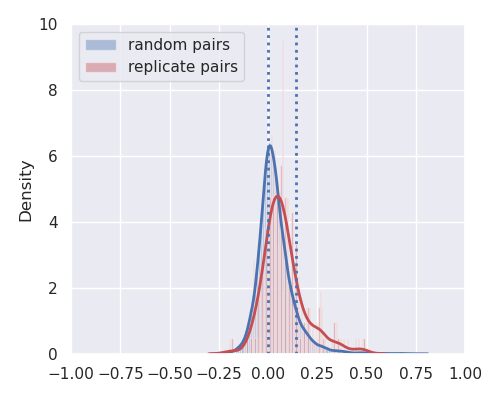

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [131]:
df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='DMSO']
x=replicateCorrs(df1,'pert_id',l1k_features,1)
# saveAsNewSheetToExistingFile(filename,x[2],'l1k-taorf')

In [45]:
# cpFeatures=plateDfwMeta.columns[plateDfwMeta.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# cols2remove0=[i for i in l1k_features if ((df1[i]=='nan').sum(axis=0)/df1.shape[0])>0.05]
# print(cols2remove0)

# cols2remove1=l1k_features[df1[l1k_features].std().values<0.00001].tolist()
# cols2remove1
# sns.set(rc={"lines.linewidth": 2})
# randC_v2,repC,highRepPertbs=x[0],x[1],x[2]
# fig, axes = plt.subplots(figsize=(5,4))

# # sns.kdeplot(randC, bw=.1, label="random pairs",ax=axes)
# # sns.kdeplot(randC_v2, bw=.1, label="random pairs",ax=axes);axes.set_xlabel('CC');
# # sns.kdeplot(repC, bw=.1, label="replicate pairs",ax=axes,color='r');axes.set_xlabel('CC');

# sns.distplot(randC_v2,kde=True,hist=True,bins=20,label="random pairs",ax=axes,norm_hist=True);
# sns.distplot(repC,kde=True,hist=True,bins=20,label="replicate pairs",ax=axes,norm_hist=True,color='r');   

# #         perc5=np.percentile(repCC, 50);axes.axvline(x=perc5,linestyle=':',color='darkorange');
# perc95=np.percentile(randC_v2, 90);axes.axvline(x=perc95,linestyle=':');
# axes.legend(loc=2);#axes.set_title('');
# axes.set_xlim(-0.8,0.8);
# plt.tight_layout()  


In [139]:
taorf_l1k_df2.groupby(['x_genesymbol_mutation']).size().describe()

count    226.000000
mean       3.225664
std        4.009706
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       56.000000
dtype: float64

In [145]:
taorf_l1k_df2.groupby(['pert_id']).size()

pert_id
BRDN0000398867     2
BRDN0000398935     1
BRDN0000398951     2
BRDN0000399101     2
BRDN0000399207     2
                  ..
BRDN0000464993     2
BRDN0000464994     2
BRDN0000464995     2
BRDN0000464996     2
DMSO              56
Length: 328, dtype: int64

In [130]:
taorf_l1k_df2.groupby(['pert_id']).size().describe()

count    328.000000
mean       2.222561
std        3.276621
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max       56.000000
dtype: float64

In [189]:
taorf_l1k_df2.columns[taorf_l1k_df2.columns.str.contains('plate')]

Index(['det_plate', 'mfc_plate_dim', 'mfc_plate_id', 'mfc_plate_name',
       'mfc_plate_quad', 'mfc_plate_well', 'rna_plate'],
      dtype='object')

In [192]:
print(taorf_l1k_df2.det_plate.unique())
print(taorf_l1k_df2.mfc_plate_dim.unique())
print(taorf_l1k_df2.mfc_plate_id.unique())
print(taorf_l1k_df2.mfc_plate_name.unique())
print(taorf_l1k_df2.mfc_plate_quad.unique())
# print(taorf_l1k_df2.mfc_plate_well.unique())
print(taorf_l1k_df2.rna_plate.unique())

['TA.OE005_U2OS_72H_X1_B15' 'TA.OE005_U2OS_72H_X2.A2_B18']
['384']
['TRCP0004010933']
['DOA60.61.62.63.A']
['1']
['TA.OE005_U2OS_72H_X1' 'TA.OE005_U2OS_72H_X2.A2']


here3


<IPython.core.display.Javascript object>


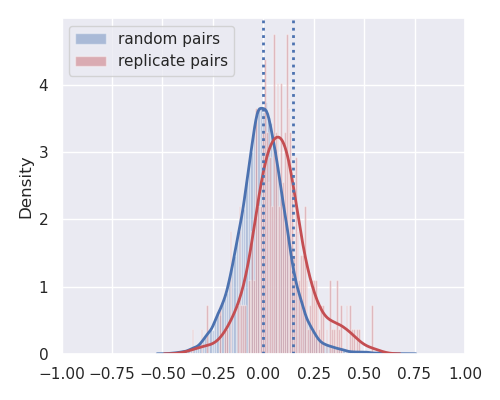

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [132]:
# df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='CMAP-000']
df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='DMSO']
df1_scaled = standardize_per_catX(df1,'det_plate',l1k_features.tolist());
x=replicateCorrs(df1_scaled,'pert_id',l1k_features,1)
# saveAsNewSheetToExistingFile(filename,x[2],'l1k-taorf')

here3


<IPython.core.display.Javascript object>


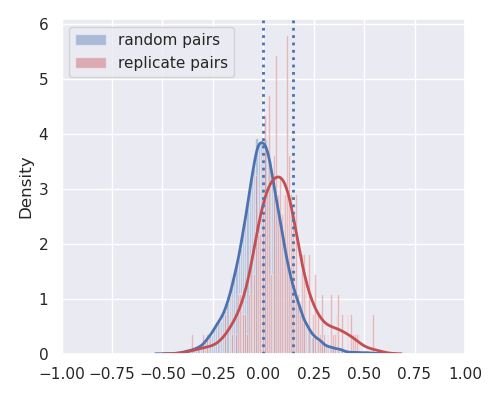

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [274]:
# df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='CMAP-000']

df1_scaled = standardize_per_catX(taorf_l1k_df2,'det_plate',l1k_features.tolist());
df1_scaled2=df1_scaled[df1_scaled['pert_id']!='DMSO']
x=replicateCorrs(df1_scaled2,'pert_id',l1k_features,1)

In [285]:
df1_scaled['218597_s_at']

0     -1.349967
1     -2.478553
2     -0.625469
3     -0.601974
4      0.400241
         ...   
724   -0.560696
725    0.442034
726   -0.040687
727    0.312065
728   -0.801582
Name: 218597_s_at, Length: 729, dtype: float64

In [284]:
df1_scaled['218597_s_at'].sample(frac = 1)

33    -0.052912
535    4.322173
313    1.175287
687    0.244403
211    2.387477
         ...   
444   -0.781582
365   -0.105313
56     2.176243
340    0.344505
470    0.180470
Name: 218597_s_at, Length: 729, dtype: float64

In [131]:
# taorf_l1k_df2['pert_id'].unique()
# saveAsNewSheetToExistingFile(filename,x[2],'l1k-taorf')
# x=replicateCorrs(df1,'pert_id',l1k_features,1)

In [50]:
# reload(replicateCorrs)
# x=replicateCorrs(df1,'pert_id',l1k_features,1)

In [72]:
# taorf_l1k_df2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k.csv',index=False)
# taorf_l1k_df2.groupby(['x_genesymbol_mutation']).size()

In [61]:
ls ~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/

replicate_level_l1k.csv        replicate_level_l1k_ZSPCQNORM.csv
replicate_level_l1k_QNORM.csv


In [208]:
x[2].to_excel(writer, index=False, sheet_name='l1k-taorf')
writer.save()

#### L1000 - CDRP

In [7]:
os.listdir(rawProf_dir+'/l1000_CDRP/')

['Broad.PNAS2014.ProfilingData',
 'cdrp.all.prof.mat',
 'cdrp.cpd.prof.mat',
 'cdrp.well.metadata.mat',
 'cdrp.well.pczscore.mat',
 'cdrp.well.prof.mat',
 'compounds.txt',
 'ge.profiles_n21983x977.gct',
 'ge.profiles_n21983x977.gctx',
 'hts.hitcounts.txt',
 'mc.profiles_n30439x812.gct',
 'mc.profiles_n30439x812.gctx',
 'readme.txt',
 'wawer.gene.all.prof.rds']

In [8]:
rawProf_dir

'/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/'

In [139]:
cdrp_dataDir=rawProf_dir+'/l1000_CDRP/'
cpd_info = pd.read_csv(cdrp_dataDir+"/compounds.txt", sep="\t", dtype=str)
cpd_info.columns

Index(['BROAD_CPD_ID', 'CPD_NAME', 'CPD_TYPE', 'CPD_SMILES'], dtype='object')

In [140]:
## Replicate level profiles
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# readRDS = robjects.r['readRDS']

# # load RDS files generated by "data_prepration_reproducible.Rmd"
# df_1 = readRDS(cdrp_dataDir+'wawer.gene.all.prof.rds')
# df_1 = pandas2ri.rpy2py_dataframe(df_1)
# df_1.head()

from scipy.io import loadmat
x = loadmat(cdrp_dataDir+'cdrp.all.prof.mat')

In [11]:
x.keys()

dict_keys(['__header__', '__version__', '__globals__', 'metaCpd', 'metaGen', 'metaNom', 'metaWell', 'nC', 'nG', 'nN', 'nW', 'pclfc', 'pclfc_mean', 'pczscore', 'pczscore_stouffer', 'vclfc', 'vczscore'])

In [14]:
loadmat(cdrp_dataDir+'cdrp.well.metadata.mat').keys()


dict_keys(['__header__', '__version__', '__globals__', 'metaWell'])

In [76]:
# x['metaCpd']

In [43]:
# det_plate

In [ ]:

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 17., 20., 25.])

In [68]:
np.sort(cdrp_l1k_rep2.pert_dose.round(0).unique())

array([-666.,    0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,
          8.,    9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,
         17.,   18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,
         26.,   27.,   29.,   30.,   33.,   40.,   50.,   53.])

In [142]:
# cpd_info.groupby(['BROAD_CPD_ID']).size().describe()

In [179]:
k1=x['metaWell']['pert_id'][0][0]
k2=x['metaGen']['AFFX_PROBE_ID'][0][0]
k3=x['metaWell']['pert_dose'][0][0]
k4=x['metaWell']['det_plate'][0][0]
# pert_dose
# x['metaWell']['pert_id'][0][0][0][0][0]
pertID = []
probID=[]
for r in range(len(k1)):
    v = k1[r][0][0]
    pertID.append(v)
#     probID.append(k2[r][0][0])

for r in range(len(k2)):
    probID.append(k2[r][0][0])
    
pert_dose=[]
det_plate=[]
for r in range(len(k3)):
    pert_dose.append(k3[r][0])
    det_plate.append(k4[r][0][0]) 
    
dataArray=x['pclfc'];
cdrp_l1k_rep = pd.DataFrame(data=dataArray,columns=probID)
cdrp_l1k_rep['pert_id']=pertID
cdrp_l1k_rep['pert_dose']=pert_dose
cdrp_l1k_rep['det_plate']=det_plate
cdrp_l1k_rep['BROAD_CPD_ID']=cdrp_l1k_rep['pert_id'].str[:13]
cdrp_l1k_rep2=pd.merge(cdrp_l1k_rep, cpd_info, how='left',on=['BROAD_CPD_ID'])
l1k_features_cdrp=cdrp_l1k_rep2.columns[cdrp_l1k_rep2.columns.str.contains("_at")]
cdrp_l1k_rep2['pert_id_dose']=cdrp_l1k_rep2['BROAD_CPD_ID']+'_'+cdrp_l1k_rep2['pert_dose'].round(2).astype(str)
cdrp_l1k_rep2['pert_sample_dose']=cdrp_l1k_rep2['pert_id']+'_'+cdrp_l1k_rep2['pert_dose'].round(2).astype(str)

# cdrp_l1k_df.head()
print(cpd_info.shape,cdrp_l1k_rep.shape,cdrp_l1k_rep2.shape)

cdrp_l1k_rep2['pert_id_dose']=cdrp_l1k_rep2['pert_id_dose'].replace('DMSO_-666.0', 'DMSO')
cdrp_l1k_rep2['pert_sample_dose']=cdrp_l1k_rep2['pert_sample_dose'].replace('DMSO_-666.0', 'DMSO')

saveDF_to_CSV_GZ_no_timestamp(cdrp_l1k_rep2,procProf_dir+'preprocessed_data/CDRP-BBBC047-Bray/L1000/replicate_level_l1k.csv.gz');
# cdrp_l1k_rep2.head()

(32324, 4) (68120, 981) (68120, 986)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3167: RuntimeWarning: compression has no effect when passing file-like object as input.
  formatter.save()


In [157]:
# cdrp_l1k_rep2['pert_id_dose']=cdrp_l1k_rep2['BROAD_CPD_ID']+'_'+cdrp_l1k_rep2['pert_dose'].round(0).astype(int).astype(str)
# cdrp_l1k_rep2['pert_sample_dose'].unique().tolist()#[-300:]
# cdrp_l1k_rep2[cdrp_l1k_rep2['pert_sample_dose']=='DMSO_-666.00']

In [254]:
saveDF_to_CSV_GZ_no_timestamp(cdrp_l1k_rep2_bioactive,procProf_dir+'preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/replicate_level_l1k.csv.gz');

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3167: RuntimeWarning: compression has no effect when passing file-like object as input.
  formatter.save()


In [176]:
# cdrp_l1k_rep2['pert_id_dose'].unique().tolist()
# cdrp_l1k_rep2['pert_dose_round']=cdrp_l1k_rep2['pert_dose'].round(0)

cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().describe()


count    21782.000000
mean         3.127353
std         24.581773
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max       3478.000000
dtype: float64

In [248]:
# repLevelCDRP2
cdrp_l1k_rep2.pert_sample_dose.unique()

array(['BRD-K07762753-001-03-6_50.0', 'BRD-K09991945-001-02-0_12.7',
       'BRD-K46678324-001-03-7_50.0', ..., 'BRD-K42541148-001-01-9_20.0',
       'BRD-K05398757-001-02-9_40.0', 'BRD-K64610608-001-02-6_20.0'],
      dtype=object)

In [249]:
repLevelCDRP2.Metadata_Sample_Dose.unique()

array(['BRD-K18250272-003-03-7_6.05', 'BRD-K18316707-001-01-9_10.0',
       'BRD-K18438502-001-02-6_10.0', ..., 'BRD-K78280988-001-02-2_1.0',
       'BRD-K78329127-001-02-9_10.0', 'BRD-K68143200-001-04-2_10.0'],
      dtype=object)

In [251]:
cdrp_l1k_rep2_bioactive=cdrp_l1k_rep2[cdrp_l1k_rep2["pert_sample_dose"].isin(repLevelCDRP2.Metadata_Sample_Dose.unique().tolist())]
cdrp_l1k_rep2_bioactive.shape,cdrp_l1k_rep2.shape

((6929, 986), (68120, 986))

In [241]:
cdrp_l1k_rep2.groupby(['pert_id_dose']).size().describe()

count    21817.000000
mean         3.122336
std         24.544542
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max       3478.000000
dtype: float64

In [242]:
cdrp_l1k_rep2.groupby(['pert_sample_dose']).size().describe()

count    21850.000000
mean         3.117620
std         24.483985
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max       3478.000000
dtype: float64

In [31]:
repSizeDF=cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>3].BROAD_CPD_ID.tolist()
highRepComp.remove('DMSO')

In [78]:
# cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().describe()
repSizeDF[repSizeDF['BROAD_CPD_ID']=='BRD-K43797669']

,BROAD_CPD_ID,0
10242,BRD-K43797669,193


In [87]:
repSizeDF[repSizeDF[0]>3].sort_values(by=[0])

,BROAD_CPD_ID,0
16309,BRD-K72676686,5
16179,BRD-K72034655,5
2831,BRD-K08438429,5
5933,BRD-K23383398,5
1089,BRD-K00007652,5
...,...,...
16159,BRD-K71879491,190
10242,BRD-K43797669,193
5008,BRD-K18910433,193
2202,BRD-K05396879,715


In [58]:
l1k_features_cdrp=cdrp_l1k_rep2.columns[cdrp_l1k_rep2.columns.str.contains("_at")]
# l1k_features_cdrp

In [59]:
# cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID'].isin(highRepComp)].groupby('BROAD_CPD_ID')[['221227_x_at','212345_s_at','218597_s_at','205500_at']]
# inDf.groupby(pertColName)[featColNames]

In [103]:
repSizeDF.sample(4).reset_index(drop=True)

,BROAD_CPD_ID,0
0,BRD-K31147195,2
1,BRD-K47551852,3
2,BRD-K78556523,3
3,BRD-K68143200,2


In [201]:
cdrp_l1k_rep2.columns

Index(['221227_x_at', '212345_s_at', '218597_s_at', '217140_s_at', '209253_at',
       '214404_x_at', '219888_at', '201225_s_at', '202535_at', '219499_at',
       ...
       '206414_s_at', '204978_at', '205379_at', '203897_at', 'pert_id',
       'pert_dose', 'BROAD_CPD_ID', 'CPD_NAME', 'CPD_TYPE', 'CPD_SMILES'],
      dtype='object', length=983)

In [42]:
# cdrp_l1k_rep2.pert_dose

In [36]:
cdrp_l1k_rep2.columns[cdrp_l1k_rep2.columns.str.contains('plate')]

Index(['det_plate'], dtype='object')

In [186]:
# l1k_features_cdrp
# cdrp_l1k_rep2.det_plate.unique()
x_cdrp_l1k[2]

,RepCor,Rand90Perc,Rep10Perc
BRD-K07762753_50.0,0.870503,0.17449,-0.123328
BRD-K09991945_12.7,0.480129,0.17449,-0.123328
BRD-K46678324_50.0,-0.11623,0.17449,-0.123328
BRD-K67860401_16.2,0.17324,0.17449,-0.123328
BRD-K52620403_12.5,0.0689012,0.17449,-0.123328
...,...,...,...
BRD-K90883684_10.01,-0.0190226,0.17449,-0.123328
BRD-K89626439_20.0,0.527366,0.17449,-0.123328
BRD-K42541148_20.0,0.211228,0.17449,-0.123328
BRD-K05398757_40.0,0.484452,0.17449,-0.123328


In [200]:
# cdrp_l1k_rep2.det_plate.unique()
cdrp_l1k_rep_scaled.pert_id_dose.unique()

array(['BRD-K07762753_50.0', 'BRD-K09991945_12.7', 'BRD-K46678324_50.0',
       ..., 'BRD-K42541148_20.0', 'BRD-K05398757_40.0',
       'BRD-K64610608_20.0'], dtype=object)

In [202]:
# import saveAsNewSheetToExistingFile
repSizeDF=cdrp_l1k_rep2.groupby(['pert_id_dose']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].pert_id_dose.tolist()
# highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')

cdrp_l1k_rep_scaled = standardize_per_catX(cdrp_l1k_rep2,'det_plate',l1k_features_cdrp.tolist());
cdrp_l1k_rep_scaled=cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_id_dose']!='DMSO']
x_cdrp_l1k=replicateCorrs(cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_id_dose'].isin(highRepComp)],\
                                      'pert_id_dose',l1k_features_cdrp,1)
# saveAsNewSheetToExistingFile(filename,x_cdrp_l1k[2],'l1k-cdrp')

#### Bioactive set

here3


<IPython.core.display.Javascript object>


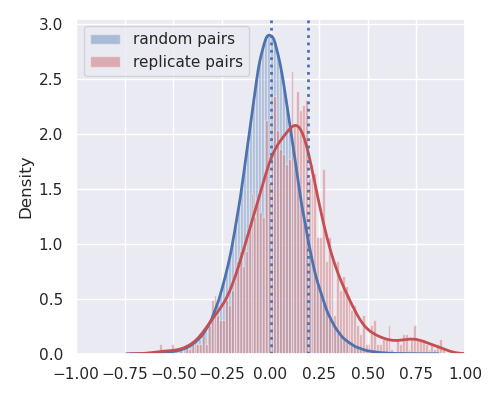

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [286]:
# cdrp_l1k_rep2_bioactive
# import saveAsNewSheetToExistingFile
repSizeDF=cdrp_l1k_rep2_bioactive.groupby(['pert_id_dose']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].pert_id_dose.tolist()
# highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')

cdrp_l1k_rep_scaled = standardize_per_catX(cdrp_l1k_rep2_bioactive,'det_plate',l1k_features_cdrp.tolist());
cdrp_l1k_rep_scaled=cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_id_dose']!='DMSO']
x_cdrp_l1k=replicateCorrs(cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_id_dose'].isin(highRepComp)],\
                                      'pert_id_dose',l1k_features_cdrp,1)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.dict_learning module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


here3


<IPython.core.display.Javascript object>


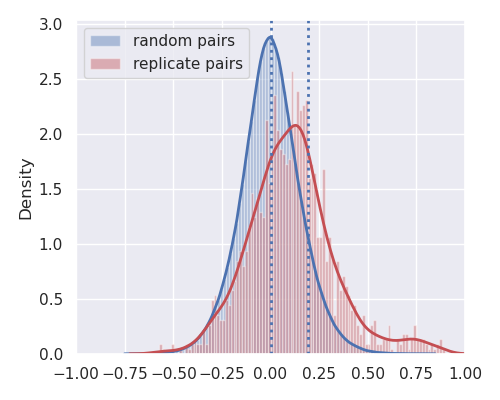

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [293]:
repSizeDF=cdrp_l1k_rep2_bioactive.groupby(['pert_sample_dose']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].pert_sample_dose.tolist()
# highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')

cdrp_l1k_rep_scaled = standardize_per_catX(cdrp_l1k_rep2_bioactive,'det_plate',l1k_features_cdrp.tolist());
cdrp_l1k_rep_scaled=cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_sample_dose']!='DMSO']
x_cdrp_l1k=replicateCorrs(cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_sample_dose'].isin(highRepComp)],\
                                      'pert_sample_dose',l1k_features_cdrp,1)

In [294]:
saveAsNewSheetToExistingFile(filename,x_cdrp_l1k[2],'l1k-cdrp-bio')

[<Worksheet "l1k-taorf">, <Worksheet "l1k-luad">, <Worksheet "l1k-lincs">, <Worksheet "cp-luad">, <Worksheet "cp-taorf">, <Worksheet "cp-lincs">, <Worksheet "l1k-cdrp">, <Worksheet "cp-cdrp">, <Worksheet "cp-cdrp-bioactive">, <Worksheet "cp-cdrp-bio">]


here2


<IPython.core.display.Javascript object>


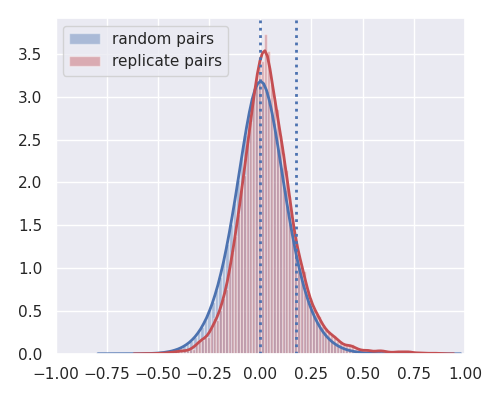

In [160]:
repSizeDF=cdrp_l1k_rep2.groupby(['pert_sample_dose']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].pert_sample_dose.tolist()
# highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')
cdrp_l1k_rep_scaled = standardize_per_catX(cdrp_l1k_rep2,'det_plate',l1k_features_cdrp.tolist());
x_cdrp_l1k=replicateCorrs(cdrp_l1k_rep_scaled[cdrp_l1k_rep_scaled['pert_sample_dose'].isin(highRepComp)],\
                                      'pert_sample_dose',l1k_features_cdrp,1)
# saveAsNewSheetToExistingFile(filename,x_cdrp_l1k[2],'l1k-cdrp')

#### Check Replicate Correlation

<IPython.core.display.Javascript object>


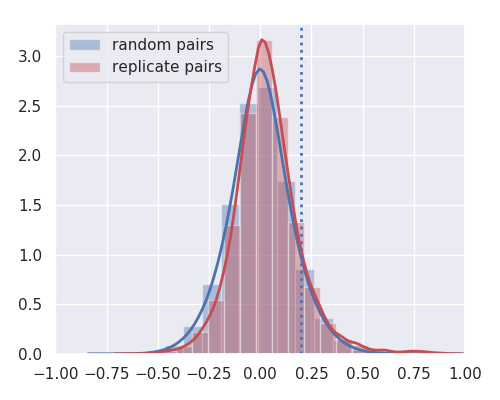

In [14]:
repSizeDF=cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].BROAD_CPD_ID.tolist()
highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')
cdrp_l1k_rep2 = standardize_per_catX(cdrp_l1k_rep2,'det_plate',l1k_features_cdrp.tolist());
x=utils.replicateCorrs.replicateCorrs(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID'].isin(highRepComp)],\
                                      'BROAD_CPD_ID',l1k_features_cdrp,1)
saveAsNewSheetToExistingFile(filename,x[2],'l1k-cdrp')

<IPython.core.display.Javascript object>


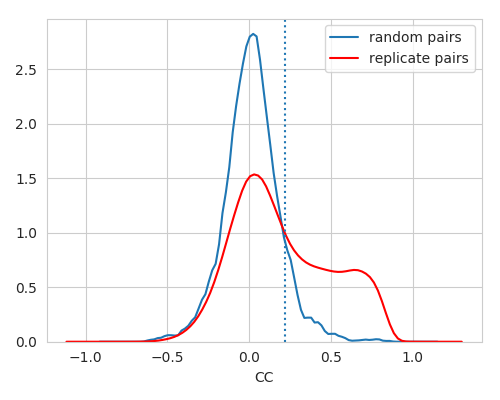

In [9]:
# import utils.replicateCorrs.replicateCorrs
import utils.replicateCorrs
reload(utils.replicateCorrs)
repSizeDF=cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>3].BROAD_CPD_ID.tolist()
highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')
x=utils.replicateCorrs.replicateCorrs(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID'].isin(highRepComp)],\
                                      'BROAD_CPD_ID',l1k_features_cdrp,1)

In [ ]:
x=replicateCorrs(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']!='DMSO'],'BROAD_CPD_ID',l1k_features,1)

In [1]:
# cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K00007652'].corrwith(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K43797669'],\
#                                                                        axis = 1,method='pearson').values.tolist()

In [107]:
cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K00007652'].corrwith(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K00007652'],\
                                                                       axis = 1,method='pearson').values.tolist()

[1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999]

In [172]:
# k3=x['metaWell']['pert_dose'][0][0]
# cdrp_l1k_rep['pert_id']=pertID
# cdrp_l1k_rep['pert_dose']=k3
# cdrp_l1k_rep['BROAD_CPD_ID']=cdrp_l1k_rep['pert_id'].str[:13]
# cdrp_l1k_rep2=pd.merge(cdrp_l1k_rep, cpd_info, how='left',on=['BROAD_CPD_ID'])
# # cdrp_l1k_df.head()
# print(cpd_info.shape,cdrp_l1k_rep.shape,cdrp_l1k_rep2.shape)
# cdrp_l1k_rep2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/replicate_level_l1k.csv',index=False)
# cdrp_l1k_rep2.head()

In [16]:
# treatmentLevel
cdrp_l1k = parse(cdrp_dataDir+"Broad.PNAS2014.ProfilingData/ge.profiles_n21983x977.gctx")
cdrp_l1k_df=cdrp_l1k.data_df.T.reset_index()
cdrp_l1k_df['XX']=cdrp_l1k_df['cid'].str[0]
cdrp_l1k_df['BROAD_CPD_ID']=cdrp_l1k_df['cid'].str[2:15]
cdrp_l1k_df2=pd.merge(cdrp_l1k_df, cpd_info, how='inner',on=['BROAD_CPD_ID'])
# cdrp_l1k_df.head()
print(cpd_info.shape,cdrp_l1k_df.shape,cdrp_l1k_df2.shape)
# cdrp_l1k_df2.to_csv(procProf_dir+'/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/treatment_level_l1k.csv.gz',index=False,compression='gzip')
saveDF_to_CSV_GZ_no_timestamp(cdrp_l1k_df2,'/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/treatment_level_l1k.csv.gz')

(32324, 4) (21983, 980) (21983, 983)


In [17]:
cdrp_l1k_df2.head()

,cid,221227_x_at,212345_s_at,218597_s_at,217140_s_at,209253_at,214404_x_at,219888_at,201225_s_at,202535_at,...,202801_at,206414_s_at,204978_at,205379_at,203897_at,XX,BROAD_CPD_ID,CPD_NAME,CPD_TYPE,CPD_SMILES
0,1:BRD-K89732114-300-06-3,-815.848145,372.501862,-439.068542,-201.406067,-269.752014,265.633698,-7.044870,-23.993784,-443.847992,...,-2.519104,-103.996338,21.385452,8.454297,-13.765161,1,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
1,2:BRD-K89732114-300-06-3,-684.512024,488.680786,-442.240326,-170.592804,-271.027771,354.551361,113.733376,-110.299194,-679.035767,...,39.128761,-99.362427,96.397514,209.599640,-66.092232,2,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
2,3:BRD-K89732114-300-07-1,-332.084930,413.534698,-285.547913,-292.624268,-214.678284,92.443077,181.307755,-208.432419,-428.033112,...,-108.442131,-14.973925,11.643245,79.470329,-0.310117,3,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
3,4:BRD-K89732114-300-07-1,-1093.123169,1363.475464,-720.515137,-359.339844,-815.420654,366.414734,88.413223,-367.906738,-1077.626831,...,-77.961143,280.649933,-257.341980,434.858887,-291.218781,4,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
4,5:BRD-K89732114-300-07-1,-2170.005859,1454.608276,-2649.765137,-933.394348,-1507.882690,1872.741455,945.424927,-395.551941,-2420.134766,...,1229.749268,839.844727,-591.371643,1262.786499,-590.441895,5,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1


In [107]:
# cdrp_l1k_df2.head()
# cdrp_l1k.head()
# cdrp_l1k_df2.groupby(['BROAD_CPD_ID']).size().mean()
# cdrp_l1k_df2.groupby(['CPD_NAME']).size()

#### L1000 - LUAD

In [12]:
os.listdir(rawProf_dir+'/l1000_LUAD/input/')

['TA.Lung_intended_clone_info_150406_confirmations_150407_WT_reference_calls_150420_ref2allele.txt',
 'TA.OE014_A549_96H.map',
 'TA.OE014_A549_96H_ZSPCINF_n2939x22268.gctx',
 'TA.OE015_A549_96H.map',
 'TA.OE015_A549_96H_ZSPCINF_n3006x22268.gctx',
 'high_rep_A549_8reps_141230_eVIP_compare_150421_conn_null.txt',
 'high_rep_A549_8reps_141230_eVIP_compare_150421_rep_null.txt',
 'landmark_probe_ids.grp',
 'lung_control_x_mutation_status.grp']

In [13]:
os.listdir(rawProf_dir+'/l1000_LUAD/output/')

['grp_files_141230',
 'high_rep_A549_8reps_141230.log',
 'high_rep_A549_8reps_141230_COMPZ.MODZ_n529x978.gctx',
 'high_rep_A549_8reps_141230_ZSPCINF_n4232x22268.gctx',
 'high_rep_A549_8reps_141230_ZSPCINF_n4232x978.gctx',
 'high_rep_A549_8reps_141230_n529x22268.gctx',
 'high_rep_A549_8reps_141230_sig.info',
 'high_rep_A549_ZSPCINF_141208_n5945x22268.gctx',
 'high_rep_A549_inst_final_141207.txt']

In [191]:
luad_dataDir=rawProf_dir+'/l1000_LUAD/'
luad_info1 = pd.read_csv(luad_dataDir+"/input/TA.OE014_A549_96H.map", sep="\t", dtype=str)
luad_info2 = pd.read_csv(luad_dataDir+"/input/TA.OE015_A549_96H.map", sep="\t", dtype=str)
luad_info=pd.concat([luad_info1, luad_info2], ignore_index=True)
luad_info.head()

,id,bead_batch,bead_revision,bead_set,cell_id,count_cv,count_mean,det_mode,det_plate,det_well,...,x_mutation_status,x_not_empty,x_number_orfs_per_gene,x_open_closed,x_orf_numbername,x_preferredgenename,x_protein_match,x_transcriptdb,zmad_ref,zmad_ref_well
0,TA.OE014_A549_96H_X1_B19:A03,b19,r2,"dp52,dp53",A549,25,33,duo,TA.OE014_A549_96H_X1_B19,A03,...,ACAT2_WT.o,-666,2,open,ORF017110.1_TRC317.1,acetoacetyl Coenzyme A thiolase|acetyl-CoA ace...,99.7,NM_005891.2,population,all
1,TA.OE014_A549_96H_X1_B19:A04,b19,r2,"dp52,dp53",A549,25,35,duo,TA.OE014_A549_96H_X1_B19,A04,...,EBNA1BP2_WT.o,-666,2,open,ORF006664.1_TRC317.1,EBNA1-binding protein 2|nuclear FGF3 binding p...,100,NM_006824.2,population,all
2,TA.OE014_A549_96H_X1_B19:A05,b19,r2,"dp52,dp53",A549,25,41,duo,TA.OE014_A549_96H_X1_B19,A05,...,BFP,-666,16,open,ORFC00001.1_TRC317.1,BFP,100,BFP.1,population,all
3,TA.OE014_A549_96H_X1_B19:A06,b19,r2,"dp52,dp53",A549,25,35,duo,TA.OE014_A549_96H_X1_B19,A06,...,HCRED,-666,16,open,ORFC00002.1_TRC317.1,HcRed,100,HcRed.1,population,all
4,TA.OE014_A549_96H_X1_B19:A07,b19,r2,"dp52,dp53",A549,24,55,duo,TA.OE014_A549_96H_X1_B19,A07,...,ABCB9_WT.c,-666,5,close,ORF024050.1_TRC317.1,ABC transporter 9 protein|ATP-binding cassette...,85.6,NM_001243014.1,population,all


In [53]:
# luad_info.shape

In [116]:
# luad_info2.x_mutation_status.unique()

In [192]:
luad_l1k_df = parse(luad_dataDir+"/output/high_rep_A549_8reps_141230_ZSPCINF_n4232x978.gctx").data_df.T.reset_index()
luad_l1k_df=luad_l1k_df.rename(columns={"cid":"id"})
# cdrp_l1k_df['XX']=cdrp_l1k_df['cid'].str[0]
# cdrp_l1k_df['BROAD_CPD_ID']=cdrp_l1k_df['cid'].str[2:15]
luad_l1k_df2=pd.merge(luad_l1k_df, luad_info, how='inner',on=['id'])
luad_l1k_df2=luad_l1k_df2.rename(columns={"x_mutation_status":"allele"})

l1k_features=luad_l1k_df2.columns[luad_l1k_df2.columns.str.contains("_at")]
luad_l1k_df2['allele']=luad_l1k_df2['allele'].replace('UnTrt', 'DMSO')
print(luad_info.shape,luad_l1k_df.shape,luad_l1k_df2.shape)
# luad_l1k_df2.to_csv(procProf_dir+'/preprocessed_data/LUAD-BBBC041-Caicedo/L1000/replicate_level_l1k.csv.gz',index=False,compression='gzip')
saveDF_to_CSV_GZ_no_timestamp(luad_l1k_df2,procProf_dir+'/preprocessed_data/LUAD-BBBC041-Caicedo/L1000/replicate_level_l1k.csv.gz')

(5945, 54) (4232, 979) (4232, 1032)


In [12]:
# luad_l1k_df2.allele.unique()
luad_l1k_df2.columns

Index(['id', '201000_at', '203192_at', '209380_s_at', '200045_at',
       '202394_s_at', '218581_at', '221552_at', '202123_s_at', '214274_s_at',
       ...
       'allele', 'x_not_empty', 'x_number_orfs_per_gene', 'x_open_closed',
       'x_orf_numbername', 'x_preferredgenename', 'x_protein_match',
       'x_transcriptdb', 'zmad_ref', 'zmad_ref_well'],
      dtype='object', length=1032)

In [197]:
# luad_l1k_df2.groupby(['allele']).size()
# luad_l1k_df2[luad_l1k_df2['allele']=='DMSO']

<IPython.core.display.Javascript object>


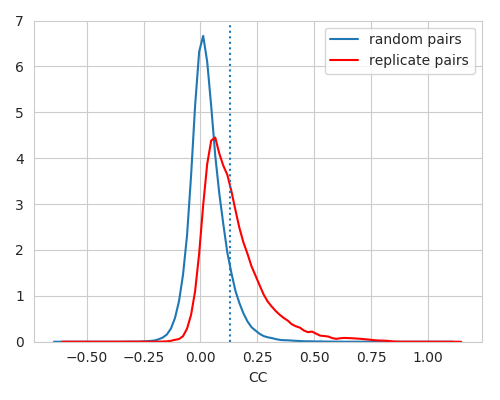

In [35]:
# x=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='UnTrt'].reset_index(drop=True).sample(100),'allele',l1k_features,1)
x_l1k_luad=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='DMSO'].reset_index(drop=True),'allele',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_luad[2],'l1k-luad')

<IPython.core.display.Javascript object>


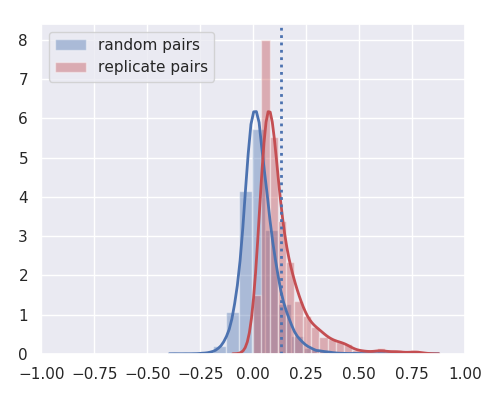

In [12]:
x=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='DMSO'].reset_index(drop=True),'allele',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'l1k-luad')

here3


<IPython.core.display.Javascript object>


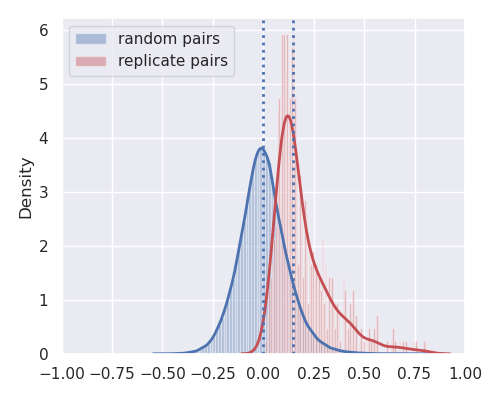

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [198]:
luad_l1k_df_scaled = standardize_per_catX(luad_l1k_df2,'det_plate',l1k_features.tolist());
x_l1k_luad=replicateCorrs(luad_l1k_df_scaled.reset_index(drop=True),'allele',l1k_features,1)
# x_l1k_luad=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='DMSO'].reset_index(drop=True),'allele',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_luad[2],'l1k-luad')

<IPython.core.display.Javascript object>


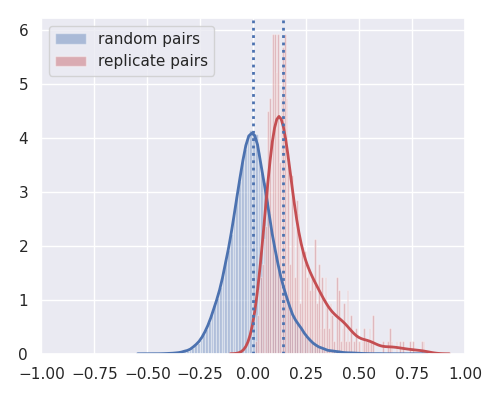

In [16]:
luad_l1k_df2 = standardize_per_catX(luad_l1k_df2,'det_plate',l1k_features.tolist());
x_l1k_luad=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='DMSO'].reset_index(drop=True),'allele',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_luad[2],'l1k-luad')

In [207]:
luad_info.det_plate.unique()

array(['TA.OE014_A549_96H_X1_B19', 'TA.OE014_A549_96H_X2_B19',
       'TA.OE014_A549_96H_X3_B19', 'TA.OE014_A549_96H_X4_B19',
       'TA.OE014_A549_96H_X5_B19', 'TA.OE014_A549_96H_X6_B19',
       'TA.OE014_A549_96H_X7_B19', 'TA.OE014_A549_96H_X8_B19',
       'TA.OE015_A549_96H_X1_B19', 'TA.OE015_A549_96H_X2_B19',
       'TA.OE015_A549_96H_X3_B19', 'TA.OE015_A549_96H_X4_B19',
       'TA.OE015_A549_96H_X5_B19', 'TA.OE015_A549_96H_X6_B19',
       'TA.OE015_A549_96H_X7_B19', 'TA.OE015_A549_96H_X8_B19'],
      dtype=object)

In [42]:
len(set(luad_l1k_df.id)-set(luad_info.id)), len(set(luad_info.id)-set(luad_l1k_df.id))

(0, 1713)

In [20]:
np.sum([x[1][i]==np.nan for i in range(len(x[1]))])

0

In [276]:
# cdrp_l1k_df.groupby(['BROAD_CPD_ID']).size()
# gene_info['CPD_TYPE'].unique()

#### L1000 - LINCS

In [3]:
os.listdir(rawProf_dir+'/l1000_LINCS/2016_04_01_a549_48hr_batch1_L1000/')

['figures',
 'level_3_q2norm_n27837x978.gctx',
 'level_4W_zspc_n27837x978.gctx',
 'level_4_zspc_n27837x978.gctx',
 'level_5_modz_cid_n9482.grp',
 'level_5_modz_common_sigs_n8370x978.gctx',
 'level_5_modz_n9482x978.gctx',
 'level_5_rank_n9482x978.gctx',
 'steep_nohup.out']

In [210]:
os.listdir(rawProf_dir+'/l1000_LINCS/metadata/')

['REP.A_A549_pert_info.txt',
 'col_meta_level_3_REP.A_A549_only_n27837.txt',
 'col_meta_level_3_n421176.txt',
 'col_meta_level_5_REP.A_A549_only_n9482.txt',
 'col_meta_level_5_n169494.txt',
 'other_cell_lines',
 'set_size_3_level_3_REP.A_A549_only_all_compounds_and_random_well_DMSO.gmt']

In [9]:
data_meta_match_ls=[['level_3','level_3_q2norm_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_4W','level_4W_zspc_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_4','level_4_zspc_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_5_modz','level_5_modz_n9482x978.gctx','col_meta_level_5_REP.A_A549_only_n9482.txt'],
                   ['level_5_rank','level_5_rank_n9482x978.gctx','col_meta_level_5_REP.A_A549_only_n9482.txt']]

In [10]:
lincs_dataDir=rawProf_dir+'/l1000_LINCS/'
lincs_pert_info = pd.read_csv(lincs_dataDir+"/metadata/REP.A_A549_pert_info.txt", sep="\t", dtype=str)
lincs_meta_level3 = pd.read_csv(lincs_dataDir+"/metadata/col_meta_level_3_REP.A_A549_only_n27837.txt", sep="\t", dtype=str)
# lincs_info1 = pd.read_csv(lincs_dataDir+"/metadata/REP.A_A549_pert_info.txt", sep="\t", dtype=str)
print(lincs_meta_level3.shape)
lincs_meta_level3.head()
# lincs_info2 = pd.read_csv(lincs_dataDir+"/input/TA.OE015_A549_96H.map", sep="\t", dtype=str)
# lincs_info=pd.concat([lincs_info1, lincs_info2], ignore_index=True)
# lincs_info.head()

(27837, 45)


,distil_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,count_mean,det_mode,det_plate,det_well,...,x_mg_per_ml,x_mmoles_per_liter,x_purity,x_smiles,x_volume_ul,pert_plate,batch,nearest_dose,brew_prefix,group_id
0,REP.A001_A549_24H_X1_B27:A03,b27,r2,"dp52,dp53",A549,39,93,duo,REP.A001_A549_24H_X1_B27,A03,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A03
1,REP.A001_A549_24H_X1_B27:A04,b27,r2,"dp52,dp53",A549,41,67,duo,REP.A001_A549_24H_X1_B27,A04,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A04
2,REP.A001_A549_24H_X1_B27:A05,b27,r2,"dp52,dp53",A549,39,109,duo,REP.A001_A549_24H_X1_B27,A05,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A05
3,REP.A001_A549_24H_X1_B27:A06,b27,r2,"dp52,dp53",A549,38,117,duo,REP.A001_A549_24H_X1_B27,A06,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A06
4,REP.A001_A549_24H_X1_B27:A07,b27,r2,"dp52,dp53",A549,40,89,duo,REP.A001_A549_24H_X1_B27,A07,...,1.10546,10,100,NNC(N)=N,13,REP.A001,REP.A,10,REP.A001_A549_24H,REP.A001_A549_24H:A07


In [12]:
# lincs_meta_level3.groupby('distil_id').size()
lincs_meta_level3['distil_id'].unique().shape

(27837,)

In [44]:
# lincs_meta_level3.columns.tolist()
# lincs_meta_level3.pert_id

In [43]:
ls /home/ubuntu/workspace_rosetta/workspace/software/2018_04_20_Rosetta/preprocessed_data/LINCS-Pilot1/CellPainting

CellPainting/  L1000/


In [7]:
# procProf_dir+'preprocessed_data/LINCS-Pilot1/'
procProf_dir

'./'

In [25]:
for el in data_meta_match_ls:
    lincs_l1k_df=parse(lincs_dataDir+"/2016_04_01_a549_48hr_batch1_L1000/"+el[1]).data_df.T.reset_index()
    lincs_meta0 = pd.read_csv(lincs_dataDir+"/metadata/"+el[2], sep="\t", dtype=str)
    lincs_meta=pd.merge(lincs_meta0, lincs_pert_info, how='left',on=['pert_id'])
    lincs_meta=lincs_meta.rename(columns={"distil_id":"cid"})
    lincs_l1k_df2=pd.merge(lincs_l1k_df, lincs_meta, how='inner',on=['cid'])
    lincs_l1k_df2['pert_id_dose']=lincs_l1k_df2['pert_id']+'_'+lincs_l1k_df2['nearest_dose'].astype(str)
    lincs_l1k_df2['pert_id_dose']=lincs_l1k_df2['pert_id_dose'].replace('DMSO_-666', 'DMSO')
#     lincs_l1k_df2.to_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+el[0]+'.csv.gz',index=False,compression='gzip')
    saveDF_to_CSV_GZ_no_timestamp(lincs_l1k_df2,procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+el[0]+'.csv.gz')

In [31]:
# lincs_l1k_df2

In [22]:
lincs_l1k_rep['pert_id_dose'].unique()

array(['DMSO_-666', 'BRD-K25114078_10', 'BRD-K25114078_3.33', ...,
       'BRD-A97502381_0.12', 'BRD-A97502381_0.04', 'BRD-A95696066_10'],
      dtype=object)

In [11]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[1][0]+'.csv.gz')
# l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
# x=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id',l1k_features,1)
# # saveAsNewSheetToExistingFile(filename,x[2],'l1k-lincs')
# # lincs_l1k_rep.head()

In [14]:
lincs_l1k_rep.pert_id.unique().shape

(1403,)

In [51]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains('dose')]

Index(['pert_dose', 'pert_dose_unit', 'pert_idose', 'nearest_dose'], dtype='object')

In [52]:
lincs_l1k_rep[['pert_dose', 'pert_dose_unit', 'pert_idose', 'nearest_dose']]

,pert_dose,pert_dose_unit,pert_idose,nearest_dose
0,-666.000000,-666,-666,-666.00
1,-666.000000,-666,-666,-666.00
2,-666.000000,-666,-666,-666.00
3,-666.000000,-666,-666,-666.00
4,10.000000,um,10 uM,10.00
...,...,...,...,...
27832,3.333330,um,3.33 uM,3.33
27833,1.111110,um,1.11 uM,1.11
27834,0.370370,um,0.37 uM,0.37
27835,0.123457,um,0.12 uM,0.12


In [53]:
lincs_l1k_rep['nearest_dose'].unique()

array([-6.66e+02,  1.00e+01,  3.33e+00,  1.11e+00,  3.70e-01,  1.20e-01,
        4.00e-02,  2.00e+01])

In [218]:
# lincs_l1k_rep.rna_plate.unique()

<IPython.core.display.Javascript object>


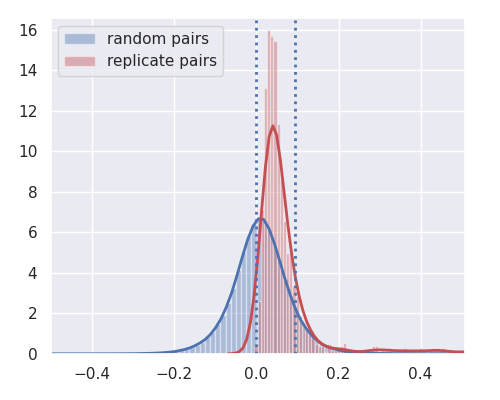

In [59]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
lincs_l1k_rep = standardize_per_catX(lincs_l1k_rep,'det_plate',l1k_features.tolist());
x=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id',l1k_features,1)

/home/ubuntu/workspace_rosetta/workspace/software/2018_04_20_Rosetta/utils/replicateCorrs.py:44: RuntimeWarning: Mean of empty slice
  repCorrDf.loc[u,'RepCor']=np.nanmean(repCorr)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


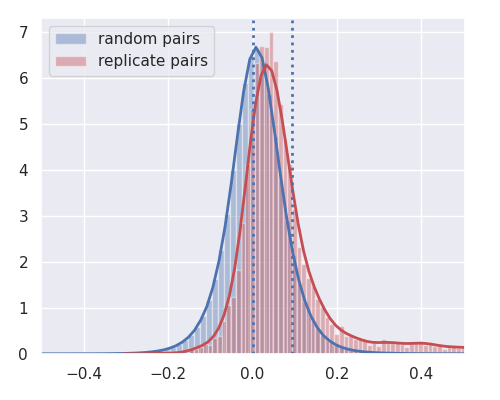

In [58]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
lincs_l1k_rep = standardize_per_catX(lincs_l1k_rep,'det_plate',l1k_features.tolist());
x_l1k_lincs=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id_dose',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_lincs[2],'l1k-lincs')

<IPython.core.display.Javascript object>


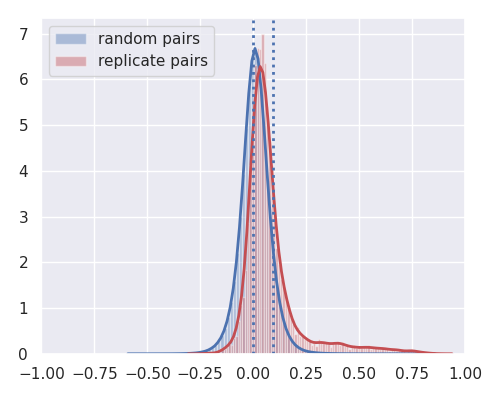

In [20]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
lincs_l1k_rep = standardize_per_catX(lincs_l1k_rep,'det_plate',l1k_features.tolist());
x_l1k_lincs=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id_dose',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_lincs[2],'l1k-lincs')

In [220]:
saveAsNewSheetToExistingFile(filename,x[2],'l1k-lincs')

### Reformat Cell-Painting Data Sets

raw data
- CDRP and TA-ORF are in /storage/data/marziehhaghighi/Rosetta/raw-profiles/
- Luad is already processed by Juan, source of the files is at /storage/luad/profiles_cp
 in case you want to reformat

#### CP - LUAD

In [102]:
ls /storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/52649/

52649.csv     52649_augmented.csv   52649_normalized_variable_selected.csv
52649.sqlite  52649_normalized.csv  52649_normalized_variable_selected.gct


In [5]:
Y1=pd.read_csv('~/workspace_rosetta/workspace/preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp.csv')
# Juan preprocessed df .   New
# 'Allele'      ----->    'x_mutation_status'
# 'Category'    ----->    ''??
# 'Clone ID'    ----->    'PublicID'
# 'Gene Symbol' ----->    'Symbol'

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir('/storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/')
for pt in profileType[1:2]:
    repLevelLuad0=[]
    for p in plates:
        repLevelLuad0.append(pd.read_csv('/storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/'+p+'/'+p+pt+'.csv'))
    repLevelLuad = pd.concat(repLevelLuad0)
    metaLuad1=pd.read_csv(rawProf_dir+'/CP_LUAD/metadata/combined_platemaps_AHB_20150506_ssedits.csv')
    metaLuad1=metaLuad1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    metaLuad1['Metadata_Well']=metaLuad1['Metadata_Well'].str.lower()
    # metaLuad2=pd.read_csv('~/workspace_rosetta/workspace/raw_profiles/CP_LUAD/metadata/barcode_platemap.csv')
    # Y[Y['Metadata_Well']=='g05']['Nuclei_Texture_Variance_Mito_5_0']
    repLevelLuad2=pd.merge(repLevelLuad, metaLuad1, how='inner',on=['Metadata_Plate_Map_Name','Metadata_Well'])
    cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
#     repLevelLuad2.to_csv(procProf_dir+'preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    saveDF_to_CSV_GZ_no_timestamp(repLevelLuad2,procProf_dir+'preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    print(metaLuad1.shape,repLevelLuad.shape,repLevelLuad2.shape)    

(1152, 14) (6144, 1802) (6144, 1814)


In [62]:
# print(repLevelLuad2.shape,Y1.shape)
# repLevelLuad2['x_mutation_status'].unique()
# repLevelLuad2
# df1

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_

<IPython.core.display.Javascript object>


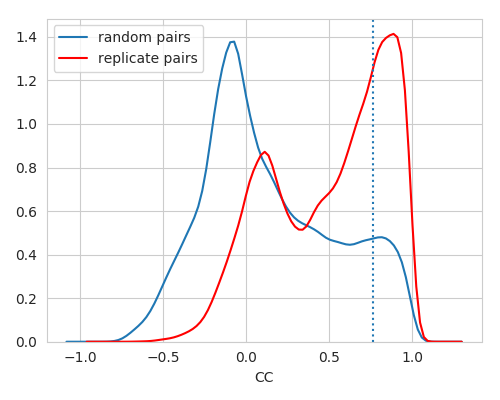

In [63]:
# repLevelTA.head()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLuad2[i].isnull()).sum(axis=0)/repLevelLuad2.shape[0])>0.05]
print(cols2remove0)
repLevelLuad2=repLevelLuad2.drop(cols2remove0, axis=1);
repLevelLuad2 = repLevelLuad2.interpolate()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelLuad2[~repLevelLuad2['x_mutation_status'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'x_mutation_status',cp_features,1)

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_

<IPython.core.display.Javascript object>


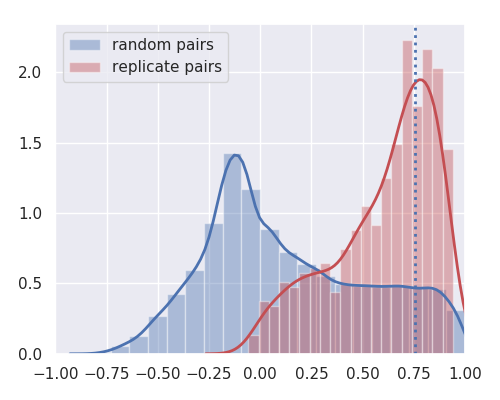

In [23]:
# repLevelTA.head()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLuad2[i].isnull()).sum(axis=0)/repLevelLuad2.shape[0])>0.05]
print(cols2remove0)
repLevelLuad2=repLevelLuad2.drop(cols2remove0, axis=1);
repLevelLuad2 = repLevelLuad2.interpolate()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelLuad2[~repLevelLuad2['x_mutation_status'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'x_mutation_status',cp_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'cp-luad')

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_

<IPython.core.display.Javascript object>


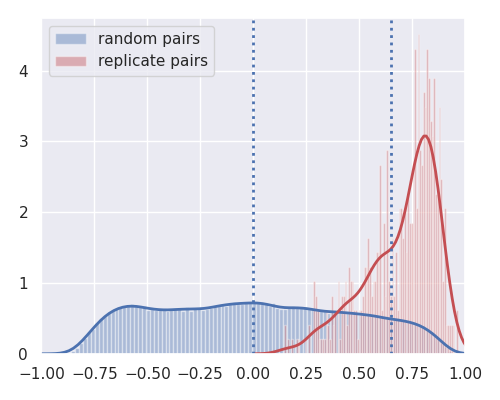

In [26]:
pt=['_normalized']
# Read save data
repLevelLuad2=pd.read_csv('./preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt[0]+'.csv.gz')

# repLevelTA.head()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLuad2[i].isnull()).sum(axis=0)/repLevelLuad2.shape[0])>0.05]
print(cols2remove0)
repLevelLuad2=repLevelLuad2.drop(cols2remove0, axis=1);
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelLuad2 = repLevelLuad2.interpolate()
repLevelLuad2 = standardize_per_catX(repLevelLuad2,'Metadata_Plate',cp_features.tolist());
df1=repLevelLuad2[~repLevelLuad2['x_mutation_status'].isnull()].reset_index(drop=True)
x_cp_luad=replicateCorrs(df1,'x_mutation_status',cp_features,1)
saveAsNewSheetToExistingFile(filename,x_cp_luad[2],'cp-luad')

In [35]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
for pt in profileType:
    repLevelLuad2=pd.read_csv('./preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    repLevelLuad2['x_mutation_status']=repLevelLuad2['x_mutation_status'].replace(np.nan, 'DMSO')
#     repLevelLuad2.to_csv(procProf_dir+'preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    saveDF_to_CSV_GZ_no_timestamp(repLevelLuad2,procProf_dir+'preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz')

In [ ]:
repLevelLuad2.x_mutation_status.unique()

In [34]:
procProf_dir

'./'

In [67]:
list(set(luadCPHighRepAlelles) & set(luadL1kHighRepAlelles)) 

['PTEN_p.M35I',
 'KEAP1_p.E218V',
 'KEAP1_p.V99L',
 'KRAS_p.G12R',
 'TP53_p.R249M',
 'CTNNB1_p.G34V',
 'RBM45_p.D434Y',
 'RARA_p.D256Y',
 'KEAP1_p.L268P',
 'TPK1_p.L185I',
 'MRPS16_WT.o',
 'MYC_p.N215I',
 'EGFR_p.V769L',
 'MAX_p.R60del',
 'TP53_p.D281Y',
 'KEAP1_WT.o',
 'CCND1_WT.c',
 'PSMG1_WT.o',
 'CTNNB1_p.S37C',
 'PIK3R3_p.R245C',
 'CTNNB1_p.S33N',
 'TSTA3_WT.o',
 'TP53_p.R181H',
 'ARAF_p.D429A',
 'GABPB1_WT.o',
 'DNAJC15_WT.o',
 'TPK1_p.K111M',
 'PIK3R3_WT.o',
 'RBM45_p.M126I',
 'KEAP1_p.G364C',
 'EGFR_p.S921R',
 'TPK1_p.P152T',
 'ABCB9_WT.o',
 'KEAP1_p.F139L',
 'RBM45_WT.c',
 'MAX_WT.c',
 'EGFR_p.L907M',
 'ARAF_p.V145L',
 'KEAP1_p.S144F',
 'KEAP1_p.G333S',
 'MAX_p.R35L',
 'ID2_WT.o',
 'EGFR_p.R1052I',
 'LAGE3_WT.o',
 'EGFR_p.S645C',
 'AKT1_p.D323Y',
 'KRAS_WT.c',
 'KEAP1_p.D389Y',
 'TPK1_p.E81Q']

In [88]:
# set(repLevelLuad2)-set(Y1.columns)

In [100]:
# Y1[['Allele', 'Category', 'Clone ID', 'Gene Symbol']].head()

In [101]:
# repLevelLuad2[repLevelLuad2['PublicID']=='BRDN0000553807'][['Col','InsertLength','NCBIGeneID','Name','OtherDescriptions','PublicID','Row','Symbol','Transcript','Vector','pert_type','x_mutation_status']].head()

#### CP - CDRP

In [107]:
ls /storage/data/marziehhaghighi/Rosetta/raw-profiles/CDRP/24277/

24277.csv     24277_augmented.csv   24277_normalized_variable_selected.csv
24277.sqlite  24277_normalized.csv


In [141]:
# repLevelCDRP4=repLevelCDRP2[['Metadata_broad_sample',"Metadata_mmoles_per_liter"]].copy()
# repLevelCDRP4["Metadata_mmoles_per_liter"]=repLevelCDRP4["Metadata_mmoles_per_liter"]*2
# repLevelCDRP4=repLevelCDRP4.drop_duplicates()
# repLevelCDRP4['dose_r']=repLevelCDRP4['Metadata_mmoles_per_liter'].round(2)

In [137]:
repLevelCDRP4=repLevelCDRP4.rename(columns={"dose_r":"pert_dose","Metadata_broad_sample":"pert_id"})


In [132]:
# cdrp_l1k_rep4

In [142]:
# comb=pd.merge(repLevelCDRP4,cdrp_l1k_rep4,how="inner",on=["pert_id","pert_dose"])
# comb

In [96]:
repLevelCDRP4.shape,cdrp_l1k_rep4.shape

((30618, 3), (21850, 2))

In [134]:
cdrp_l1k_rep4=cdrp_l1k_rep2[["pert_id","pert_dose"]].drop_duplicates()
cdrp_l1k_rep4['pert_dose']=cdrp_l1k_rep4['pert_dose'].round(2)

In [90]:
cdrp_l1k_rep4[cdrp_l1k_rep4['pert_id']=="BRD-K18316707-001-01-9"]

,pert_id,pert_dose
67469,BRD-K18316707-001-01-9,10.0


In [68]:
repLevelCDRP2.groupby(['Metadata_broad_sample','Metadata_pert_id']).size()

Metadata_broad_sample   Metadata_pert_id
BRD-A00037023-001-05-1  BRD-A00037023           4
BRD-A00051892-001-05-0  BRD-A00051892           4
BRD-A00100033-001-04-8  BRD-A00100033           8
BRD-A00214921-001-04-2  BRD-A00214921           4
BRD-A00250346-001-05-0  BRD-A00250346           4
                                            ...  
BRD-M97925630-001-01-1  BRD-M97925630           4
BRD-M98484762-001-01-8  BRD-M98484762           4
BRD-U48977771-000-01-3  BRD-U48977771           3
BRD-U62737497-000-01-5  BRD-U62737497           4
DMSO                    DMSO                26572
Length: 30617, dtype: int64

In [67]:
repLevelCDRP2.groupby(['Metadata_broad_sample']).size().describe()

count    30617.000000
mean         5.009831
std        151.840426
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max      26572.000000
dtype: float64

In [54]:
metaCDRP1=pd.read_csv(rawProf_dir+'/CP_CDRP/metadata/metadata_CDRP.csv')

In [59]:
metaCDRP1[metaCDRP1["Metadata_pert_iname"]=='fluvoxamine']

,Metadata_broad_sample,Metadata_pert_iname,Metadata_pert_iname2,Metadata_moa,Metadata_target
743,BRD-K72676686-103-01-8,fluvoxamine,BRD-K72676686,selective serotonin reuptake inhibitor (SSRI)|...,"SLC6A4, CYP2C19"


In [140]:
# repLevelCDRP4=repLevelCDRP2[['Metadata_broad_sample',"Metadata_mmoles_per_liter"]].copy()
# repLevelCDRP4["Metadata_mmoles_per_liter"]=repLevelCDRP4["Metadata_mmoles_per_liter"]*2
# repLevelCDRP4=repLevelCDRP4.drop_duplicates()
# repLevelCDRP4['dose_r']=repLevelCDRP4['Metadata_mmoles_per_liter'].round(2)

In [6]:
# bioactiveFlag="";# either "-bioactive" or ""
# if bioactiveFlag:
#     print('t')

In [11]:
profileType=['_augmented','_normalized','_normalized_variable_selected']

bioactiveFlag="";# either "-bioactive" or ""

plates=os.listdir(rawProf_dir+'/CDRP'+bioactiveFlag+'/')
for pt in profileType[0:2]:
    repLevelCDRP0=[]
    for p in plates:
#         repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP/'+p+'/'+p+pt+'.csv'))
        repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP'+bioactiveFlag+'/'+p+'/'+p+pt+'.csv')) #if bioactive
    repLevelCDRP = pd.concat(repLevelCDRP0)
    metaCDRP1=pd.read_csv(rawProf_dir+'/CP_CDRP/metadata/metadata_CDRP.csv')
    # metaCDRP1=metaCDRP1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    # metaCDRP1['Metadata_Well']=metaCDRP1['Metadata_Well'].str.lower()
    repLevelCDRP2=pd.merge(repLevelCDRP, metaCDRP1, how='left',on=['Metadata_broad_sample'])
#     repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_broad_sample']+'_'+repLevelCDRP2['Metadata_mmoles_per_liter'].round(0).astype(int).astype(str)
#     repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_pert_id']+'_'+(repLevelCDRP2['Metadata_mmoles_per_liter']*2).round(0).astype(int).astype(str)
    repLevelCDRP2["Metadata_mmoles_per_liter2"]=(repLevelCDRP2["Metadata_mmoles_per_liter"]*2).round(2)
    repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_broad_sample']+'_'+repLevelCDRP2['Metadata_mmoles_per_liter2'].astype(str)

    repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_Sample_Dose'].replace('DMSO_0.0', 'DMSO')
    repLevelCDRP2['Metadata_pert_id']=repLevelCDRP2['Metadata_pert_id'].replace(np.nan, 'DMSO')
    
#     repLevelCDRP2.to_csv(procProf_dir+'preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')

# ,
    if bioactiveFlag:
        dataFolderName='CDRPBIO-BBBC036-Bray'
        saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                      '/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    else:
        dataFolderName='CDRP-BBBC047-Bray'
        saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                      '/CellPainting/replicate_level_cp'+pt+'.csv.gz')

    print(metaCDRP1.shape,repLevelCDRP.shape,repLevelCDRP2.shape)

(1553, 5) (153370, 1800) (153386, 1806)
(1553, 5) (153370, 1800) (153386, 1806)


In [52]:
repLevelCDRP2['Metadata_pert_id']=repLevelCDRP2['Metadata_pert_id'].replace(np.nan, 'DMSO')
saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp'+pt+'.csv.gz')


In [ ]:
# repLevelCDRP3=repLevelCDRP2.copy()
# repLevelCDRP3['Metadata_mmoles_per_liter_rounded']=repLevelCDRP3['Metadata_mmoles_per_liter'].round(0).astype(int)
# repLevelCDRP3.groupby(['Metadata_mmoles_per_liter_rounded']).size()
# repLevelCDRP2['Metadata_pert_id'].unique().tolist()
Metadata_broad_sample

In [253]:
# repLevelCDRP2.to_csv(procProf_dir+'preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
repLevelCDRP2.groupby(['Metadata_pert_id']).size()

Metadata_pert_id
BRD-A00100033       8
BRD-A00267231       8
BRD-A00327403       8
BRD-A00520476       8
BRD-A00827783       8
                 ... 
BRD-K98174813       8
BRD-K98281970       8
BRD-K98297262       8
BRD-K98521173       8
DMSO             3528
Length: 2239, dtype: int64

In [234]:
repLevelCDRP2.groupby(['Metadata_Sample_Dose']).size().describe()

count    30618.000000
mean         5.009668
std        151.837946
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max      26572.000000
dtype: float64

In [239]:
repLevelCDRP2.groupby(["Metadata_pert_id","Metadata_mmoles_per_liter2"]).size()

Metadata_pert_id  Metadata_mmoles_per_liter2
BRD-A00037023     10.00                             4
BRD-A00051892     10.00                             4
BRD-A00100033     6.96                              8
BRD-A00214921     10.00                             4
BRD-A00250346     10.00                             4
                                                ...  
BRD-M97925630     9.97                              4
BRD-M98484762     9.96                              4
BRD-U48977771     10.00                             3
BRD-U62737497     10.00                             4
DMSO              0.00                          26572
Length: 30598, dtype: int64

<IPython.core.display.Javascript object>


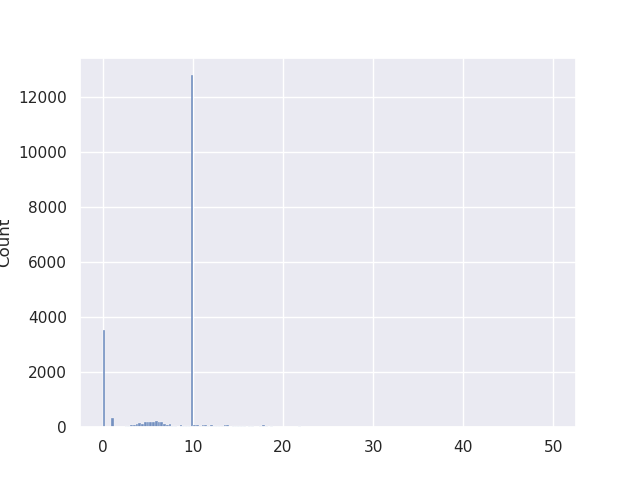

In [272]:
import seaborn as sns
plt.figure()
sns.histplot(repLevelCDRP2.Metadata_mmoles_per_liter2.values)

In [223]:
repLevelCDRP3_scaled['Metadata_broad_sample'].unique().tolist()

['BRD-K18250272-003-03-7',
 'BRD-K18316707-001-01-9',
 'BRD-K18438502-001-02-6',
 'BRD-K18550767-001-02-8',
 'BRD-K18574842-323-03-3',
 'BRD-K18619710-001-03-7',
 'BRD-K18742343-001-03-2',
 'BRD-K18757346-001-02-9',
 'BRD-K18779551-003-03-7',
 'BRD-K18787491-001-05-2',
 'BRD-K18799075-001-01-0',
 'BRD-K18816859-001-01-4',
 'DMSO',
 'BRD-K18909381-001-01-4',
 'BRD-K18910433-001-04-4',
 'BRD-K18922609-004-04-1',
 'BRD-K19040732-300-01-9',
 'BRD-K19111024-001-04-3',
 'BRD-K19295594-001-04-4',
 'BRD-K19309090-300-03-0',
 'BRD-K19352500-332-03-7',
 'BRD-K19360254-001-01-3',
 'BRD-K19438463-001-01-4',
 'BRD-K19462402-003-03-0',
 'BRD-K19507340-001-03-1',
 'BRD-K19533706-001-01-9',
 'BRD-K19554809-001-01-1',
 'BRD-K19605405-001-01-9',
 'BRD-K20043699-001-02-3',
 'BRD-K20141153-003-03-8',
 'BRD-K20152659-001-02-0',
 'BRD-K20420220-001-02-1',
 'BRD-K20620780-001-01-0',
 'BRD-K20655524-003-04-7',
 'BRD-K20672254-046-02-1',
 'BRD-K20714604-001-01-5',
 'BRD-K20742498-001-01-5',
 'BRD-K20755323-001

In [9]:
# repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_Sample_Dose'].replace(np.nan, 'DMSO')

In [63]:
repLevelCDRP2.columns[repLevelCDRP2.columns.str.contains('Metadata')]

Index(['Metadata_Plate', 'Metadata_Well', 'Metadata_Assay_Plate_Barcode',
       'Metadata_Plate_Map_Name', 'Metadata_well_position',
       'Metadata_ASSAY_WELL_ROLE', 'Metadata_broad_sample',
       'Metadata_mmoles_per_liter', 'Metadata_solvent', 'Metadata_pert_id',
       'Metadata_pert_mfc_id', 'Metadata_pert_well', 'Metadata_pert_id_vendor',
       'Metadata_cell_id', 'Metadata_broad_sample_type',
       'Metadata_pert_vehicle', 'Metadata_pert_type', 'Metadata_pert_iname',
       'Metadata_pert_iname2', 'Metadata_moa', 'Metadata_target'],
      dtype='object')

In [8]:
repLevelCDRP2['Metadata_Sample_Dose'].unique().tolist()

['BRD-K18250272_3',
 'BRD-K18316707_5',
 'BRD-K18438502_5',
 'BRD-K18550767_5',
 'BRD-K18574842_2',
 'BRD-K18619710_3',
 'BRD-K18742343_5',
 'BRD-K18757346_0',
 'BRD-K18779551_5',
 'BRD-K18787491_7',
 'BRD-K18799075_5',
 'BRD-K18816859_5',
 'DMSO',
 'BRD-K18909381_5',
 'BRD-K18910433_9',
 'BRD-K18922609_3',
 'BRD-K19040732_4',
 'BRD-K19111024_5',
 'BRD-K19295594_5',
 'BRD-K19309090_3',
 'BRD-K19352500_2',
 'BRD-K19360254_5',
 'BRD-K19438463_5',
 'BRD-K19462402_3',
 'BRD-K19507340_3',
 'BRD-K19533706_5',
 'BRD-K19554809_5',
 'BRD-K19605405_5',
 'BRD-K20043699_5',
 'BRD-K20141153_5',
 'BRD-K20152659_0',
 'BRD-K20420220_5',
 'BRD-K20620780_5',
 'BRD-K20655524_3',
 'BRD-K20672254_3',
 'BRD-K20714604_5',
 'BRD-K20742498_5',
 'BRD-K20755323_5',
 'BRD-K20995441_5',
 'BRD-K21283037_5',
 'BRD-K21350491_8',
 'BRD-K21450440_5',
 'BRD-K21520694_5',
 'BRD-K21548250_6',
 'BRD-K21565985_5',
 'BRD-K21667562_5',
 'BRD-K21680192_2',
 'BRD-K21733600_5',
 'BRD-K21853356_9',
 'BRD-K21893543_5',
 'BRD-K2191

In [147]:
repLevelCDRP2['Metadata_broad_sample'].unique()

array(['BRD-K18250272-003-03-7', 'BRD-K18316707-001-01-9',
       'BRD-K18438502-001-02-6', ..., 'BRD-K06039860-001-02-2',
       'BRD-K31618614-001-02-1', 'BRD-K31618614-001-01-3'], dtype=object)

In [67]:
np.sort(repLevelCDRP2.Metadata_mmoles_per_liter.round(0).unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 17., 20., 25.])

In [79]:
repLevelCDRP2.Metadata_mmoles_per_liter.round(0).astype(int).astype(str)

0         3
1         5
2         5
3         5
4         2
         ..
153381    5
153382    5
153383    5
153384    5
153385    5
Name: Metadata_mmoles_per_liter, Length: 153386, dtype: object

In [ ]:
metaCDRP1[metaCDRP1['Metadata_broad_sample']=='BRD-A01320529-001-05-9'] 
# BRD-A13084692-001-05-8

In [69]:
metaCDRP1.head()

,Metadata_broad_sample,Metadata_pert_iname,Metadata_pert_iname2,Metadata_moa,Metadata_target
0,BRD-A01078468-001-04-9,hexestrol,hexestrol,synthetic estrogen,"AKR1C1, ESR1, ESR2"
1,BRD-A01320529-001-05-9,salmeterol,salmeterol,adrenergic receptor agonist,ADRB2
2,BRD-A01593789-001-01-5,chlormadinone-acetate,chlormadinone acetate,5 alpha reductase inhibitor,PGR
3,BRD-A01636364-003-04-5,bupivacaine,bupivacaine,sodium channel blocker,"KCNA5, PTGER1, SCN10A, SCN4A"
4,BRD-A01787639-003-08-6,naftopidil,naftopidil,adrenergic receptor antagonist,ADRA1A


#### Check Replicate Correlation

here2


<IPython.core.display.Javascript object>


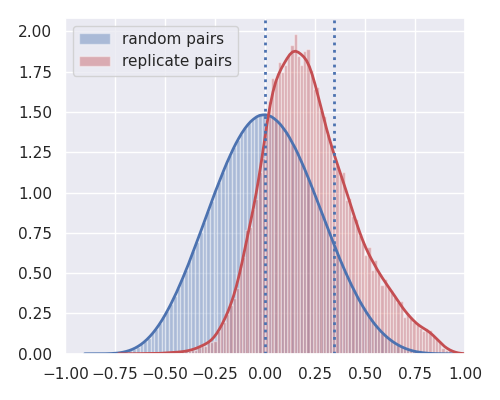

In [7]:
# repLevelTA.head()
cp_features=repLevelCDRP2.columns[repLevelCDRP2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelCDRP2[i].isnull()).sum(axis=0)/repLevelCDRP2.shape[0])>0.05]
# print(cols2remove0)
repLevelCDRP3=repLevelCDRP2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelCDRP3 = repLevelCDRP3.interpolate()
cp_features=repLevelCDRP3.columns[repLevelCDRP3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelCDRP3 = standardize_per_catX(repLevelCDRP3,'Metadata_Plate',cp_features.tolist());
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# repSizeDF=repLevelCDRP3.groupby(['Metadata_Sample_Dose']).size().reset_index()
# highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_Sample_Dose.tolist()
# highRepComp.remove('DMSO')
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_Sample_Dose'].isin(highRepComp)]
x_cdrp_cp=replicateCorrs(repLevelCDRP3,'Metadata_Sample_Dose',cp_features,1)
saveAsNewSheetToExistingFile(filename,x_cdrp_cp[2],'cp-cdrp')

#### Just bioactive

(21122, 624)
(17594, 624)
here3


<IPython.core.display.Javascript object>


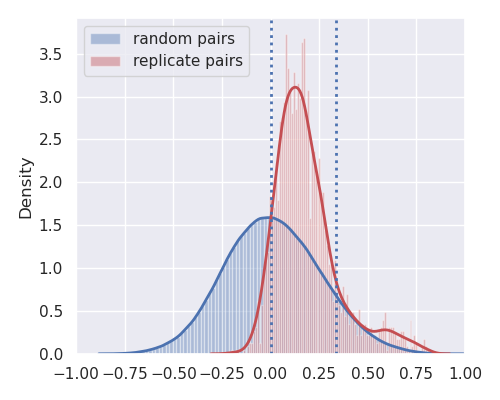

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [226]:
# repLevelTA.head()
cp_features=repLevelCDRP2.columns[repLevelCDRP2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelCDRP2[i].isnull()).sum(axis=0)/repLevelCDRP2.shape[0])>0.05]
# print(cols2remove0)
repLevelCDRP3=repLevelCDRP2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelCDRP3 = repLevelCDRP3.interpolate()
cp_features=repLevelCDRP3.columns[repLevelCDRP3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelCDRP3_scaled = standardize_per_catX(repLevelCDRP3,'Metadata_Plate',cp_features.tolist());
print(repLevelCDRP3_scaled.shape)
repLevelCDRP3_scaled=repLevelCDRP3_scaled[repLevelCDRP3_scaled['Metadata_Sample_Dose']!='DMSO'].reset_index(drop=True)
print(repLevelCDRP3_scaled.shape)
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# repSizeDF=repLevelCDRP3.groupby(['Metadata_Sample_Dose']).size().reset_index()
# highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_Sample_Dose.tolist()
# highRepComp.remove('DMSO')
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_Sample_Dose'].isin(highRepComp)]
x_cdrp_cp=replicateCorrs(repLevelCDRP3_scaled,'Metadata_Sample_Dose',cp_features,1)
saveAsNewSheetToExistingFile(filename,x_cdrp_cp[2],'cp-cdrp-bio')

In [292]:
saveAsNewSheetToExistingFile(filename,x_cdrp_cp[2],'cp-cdrp-bio')

[<Worksheet "l1k-taorf">, <Worksheet "l1k-luad">, <Worksheet "l1k-lincs">, <Worksheet "cp-luad">, <Worksheet "cp-taorf">, <Worksheet "cp-lincs">, <Worksheet "l1k-cdrp">, <Worksheet "cp-cdrp">, <Worksheet "cp-cdrp-bioactive">, <Worksheet "l1k-cdrp-bio">]


['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_Mito', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_DNA', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_ER_AGP', 'Cells_Correlation_Mand

<IPython.core.display.Javascript object>


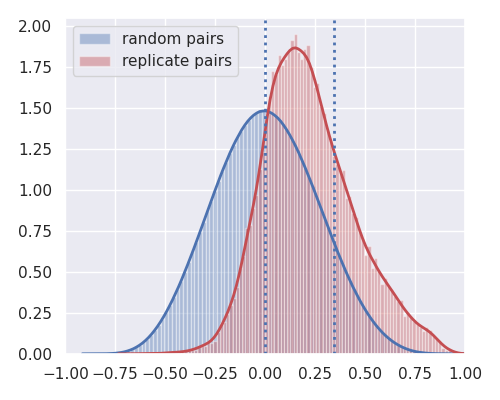

In [54]:
cp_features=repLevelCDRP2.columns[repLevelCDRP2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelCDRP2[i].isnull()).sum(axis=0)/repLevelCDRP2.shape[0])>0.05]
print(cols2remove0)
repLevelCDRP3=repLevelCDRP2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelCDRP3 = repLevelCDRP3.interpolate()
cp_features=repLevelCDRP3.columns[repLevelCDRP3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelCDRP3 = standardize_per_catX(repLevelCDRP3,'Metadata_Plate',cp_features.tolist());
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# repSizeDF=repLevelCDRP3.groupby(['Metadata_pert_id']).size().reset_index()
# highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_Sample_Dose.tolist()
# highRepComp.remove('DMSO')
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_Sample_Dose'].isin(highRepComp)]
x_cdrp_cp=replicateCorrs(repLevelCDRP3,'Metadata_pert_id',cp_features,1)
saveAsNewSheetToExistingFile(filename,x_cdrp_cp[2],'cp-cdrp')

<IPython.core.display.Javascript object>


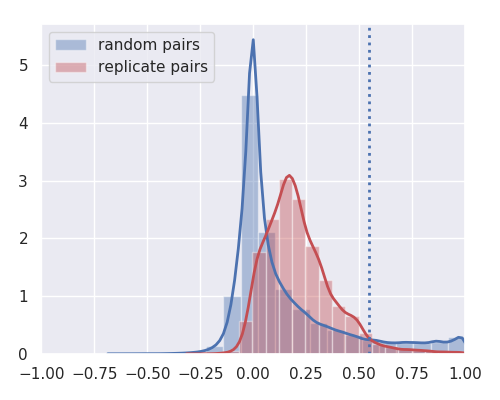

In [57]:
# cp_features
# import random
# random.sample(featColNames.tolist(),100)
# featColNames.tolist()
# randC_v2

repC=repCorrDf.RepCor.values
repC = [repC for repC in repC if str(repC) != 'nan']
randC_v2 = [randC_v2 for randC_v2 in randC_v2 if str(randC_v2) != 'nan']    
if plotEnabled:
    fig, axes = plt.subplots(figsize=(5,4))
#         sns.kdeplot(randC_v2, bw=.1, label="random pairs",ax=axes);axes.set_xlabel('CC');
#         sns.kdeplot(repC, bw=.1, label="replicate pairs",ax=axes,color='r');axes.set_xlabel('CC');
    sns.distplot(randC_v2,kde=True,hist=True,bins=20,label="random pairs",ax=axes,norm_hist=True);
    sns.distplot(repC,kde=True,hist=True,bins=20,label="replicate pairs",ax=axes,norm_hist=True,color='r');   

    #         perc5=np.percentile(repCC, 50);axes.axvline(x=perc5,linestyle=':',color='darkorange');
    axes.axvline(x=perc95,linestyle=':');
    axes.legend(loc=2);#axes.set_title('');
    axes.set_xlim(-1,1);
    plt.tight_layout() 

repCorrDf['Rand90Perc']=perc95

In [79]:
repCorrDf3=pd.read_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_corr_DF_'+pt+'.csv')

In [12]:
repCorrDf.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_corr_DF_'+pt+'.csv',index=False)

In [19]:
# repCorrDf

#### CP - TA-ORF

In [123]:
ls ~/workspace_rosetta/workspace/raw_profiles/CP_TA_ORF/metadata/

metadata_TA.csv  metadata_TA_2.csv


In [ ]:
# ls /storage/data/marziehhaghighi/Rosetta/raw-profiles/TA-ORF-BBBC037-Rohban/41757
# repLevelTA
# metaTA2

In [255]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir(rawProf_dir+'TA-ORF-BBBC037-Rohban/')
for pt in profileType[0:1]:
    repLevelTA0=[]
    for p in plates:
        repLevelTA0.append(pd.read_csv(rawProf_dir+'TA-ORF-BBBC037-Rohban/'+p+'/'+p+pt+'.csv'))
    repLevelTA = pd.concat(repLevelTA0)
    metaTA1=pd.read_csv(rawProf_dir+'/CP_TA_ORF/metadata/metadata_TA.csv')
    metaTA2=pd.read_csv(rawProf_dir+'/CP_TA_ORF/metadata/metadata_TA_2.csv')
#     metaTA2=metaTA2.rename(columns={"Metadata_broad_sample":"Metadata_broad_sample_2",'Metadata_Treatment':'Gene Allele Name'})
    metaTA=pd.merge(metaTA2, metaTA1, how='left',on=['Metadata_broad_sample'])
#     metaTA2=metaTA2.rename(columns={"Metadata_Treatment":"Metadata_pert_name"})
#     repLevelTA2=pd.merge(repLevelTA, metaTA2, how='left',on=['Metadata_pert_name'])
    repLevelTA2=pd.merge(repLevelTA, metaTA, how='left',on=['Metadata_broad_sample'])

#     repLevelTA2=repLevelTA2.rename(columns={"Gene Allele Name":"Allele"})
    repLevelTA2['Metadata_broad_sample']=repLevelTA2['Metadata_broad_sample'].replace(np.nan, 'DMSO')
#     repLevelTA2.to_csv(procProf_dir+'/preprocessed_data/TA-ORF-BBBC037-Rohban/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
#     saveDF_to_CSV_GZ_no_timestamp(repLevelTA2,procProf_dir+'/preprocessed_data/TA-ORF-BBBC037-Rohban/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    print(metaTA.shape,repLevelTA.shape,repLevelTA2.shape)


(323, 4) (1920, 1801) (1920, 1804)


In [256]:
repLevelTA2.groupby(['Metadata_broad_sample']).size()

Metadata_broad_sample
BRDN0000464846        5
BRDN0000464847        5
BRDN0000464848        5
BRDN0000464849        5
BRDN0000464850        5
                     ..
ccsbBroad304_14956    5
ccsbBroad304_14974    5
ccsbBroad304_15022    5
ccsbBroad304_15050    5
ccsbBroad304_15196    5
Length: 324, dtype: int64

In [260]:
# repLevelTA2[repLevelTA2['Metadata_broad_sample']=='DMSO']
repLevelTA[]

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,41744,a01,41744,TAORF_REFERENCE_SET,a01,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,2.886774,1.440687,1.506719,1.484461,1.245067,1.300214,1.250547,2.549217,2.549292,2.580768
1,41744,a02,41744,TAORF_REFERENCE_SET,a02,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,2.830184,1.515587,1.529815,1.523954,1.304125,1.409949,1.357492,2.565789,2.571296,2.606567
2,41744,a03,41744,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,2.786452,1.516549,1.478524,1.460322,1.375558,1.413097,1.415326,2.575652,2.621210,2.668294
3,41744,a04,41744,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,2.827228,1.407649,1.492252,1.454440,1.299621,1.330510,1.304007,2.595669,2.626601,2.649400
4,41744,a05,41744,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,2.761550,1.438448,1.444328,1.422024,1.343384,1.410478,1.379160,2.615251,2.654130,2.695320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,41757,p20,41757,TAORF_REFERENCE_SET,p20,eGFP,eGFP_CTRL,NaN,U2OS,CTRL,...,2.891152,1.403858,1.471153,1.444121,1.280762,1.338451,1.300881,2.660204,2.710194,2.731972
380,41757,p21,41757,TAORF_REFERENCE_SET,p21,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,2.764063,1.282762,1.343495,1.347930,1.270993,1.321114,1.289762,2.778403,2.716907,2.769703
381,41757,p22,41757,TAORF_REFERENCE_SET,p22,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,2.953324,1.387788,1.430706,1.427632,1.304008,1.321635,1.304950,2.657927,2.626585,2.687136
382,41757,p23,41757,TAORF_REFERENCE_SET,p23,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,2.862459,1.444390,1.510803,1.483656,1.309891,1.378696,1.331808,2.636991,2.641285,2.700773


In [82]:
gsk_check=['GSK3B_WT.1', 'GSK3B_WT.2','EMPTY_']
repLevelTA2[repLevelTA2["Metadata_pert_name"].isin(gsk_check)]\
[["Metadata_pert_name","Cells_RadialDistribution_MeanFrac_Mito_4of4"]].groupby(['Metadata_pert_name']).describe()

Cells_RadialDistribution_MeanFrac_Mito_4of4            \
                                                         count      mean   
Metadata_pert_name                                                         
EMPTY_                                                   175.0 -0.006838   
GSK3B_WT.1                                                 5.0 -0.157979   
GSK3B_WT.2                                                 5.0  0.045749   

                                                                                
                         std       min       25%       50%       75%       max  
Metadata_pert_name                                                              
EMPTY_              0.144997 -0.335337 -0.104997 -0.002568  0.073197  0.513201  
GSK3B_WT.1          0.149826 -0.364115 -0.271442 -0.059794 -0.058976 -0.035570  
GSK3B_WT.2          0.135244 -0.153418 -0.010081  0.071407  0.119050  0.201787

<IPython.core.display.Javascript object>


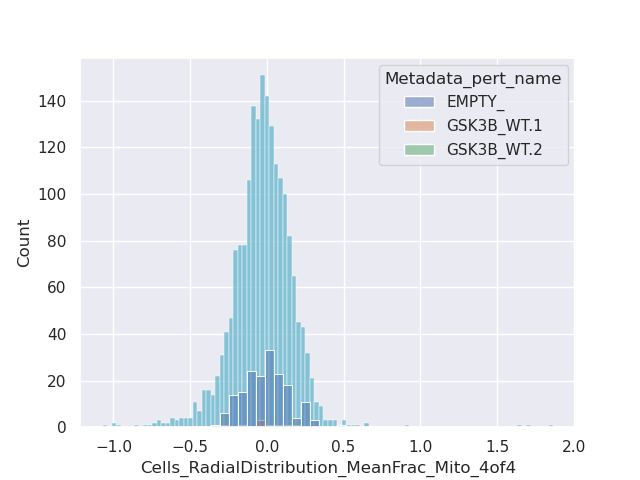

In [86]:
plt.figure()
sns.histplot(data=repLevelTA2, x="Cells_RadialDistribution_MeanFrac_Mito_4of4", bins=100,color='c')

<IPython.core.display.Javascript object>


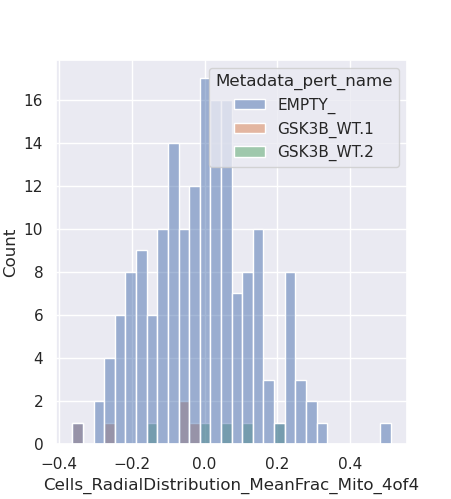

In [93]:
plt.figure()
sns.histplot(data=repLevelTA2[repLevelTA2["Metadata_pert_name"].isin(gsk_check)],\
             x="Cells_RadialDistribution_MeanFrac_Mito_4of4", hue="Metadata_pert_name",bins=30)

In [74]:
# lss=repLevelTA2["Metadata_pert_name"].astype(str).unique().tolist()
# [l for l in lss if "GSK" in l]
repLevelTA2.columns[repLevelTA2.columns.str.contains("_RadialDistribution_MeanFrac_Mito_4of4")]

Index(['Cells_RadialDistribution_MeanFrac_Mito_4of4',
       'Cytoplasm_RadialDistribution_MeanFrac_Mito_4of4',
       'Nuclei_RadialDistribution_MeanFrac_Mito_4of4'],
      dtype='object')

In [116]:
repLevelTA[repLevelTA['Metadata_broad_sample'].isnull()]['Metadata_pert_name'].unique()

array(['EMPTY_', 'Luciferase_CTRL', 'LacZ_CTRL', 'eGFP_CTRL'],
      dtype=object)

In [50]:
df1[cp_features].isnull().sum().sum()

166594

In [75]:
[i for i in cp_features2 if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0]

[]

[]


<IPython.core.display.Javascript object>


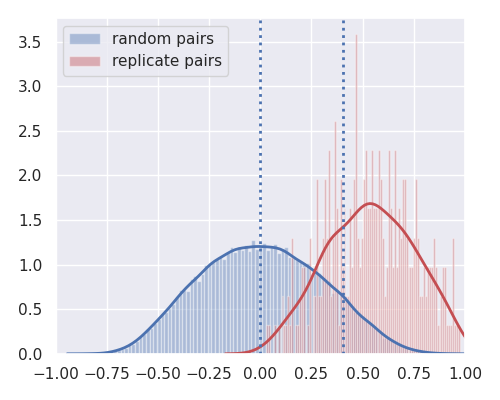

In [40]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelTA2 = standardize_per_catX(repLevelTA2,'Metadata_Plate',cp_features.tolist());
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x_taorf_cp=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)
saveAsNewSheetToExistingFile(filename,x_taorf_cp[2],'cp-taorf')

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_ER', 'Cells_Correlation_Costes_DNA_Mito', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_ER_AGP', 'Cells_Correlation_Manders_ER_Mito', 'Cells_Correlation_Manders_R

<IPython.core.display.Javascript object>


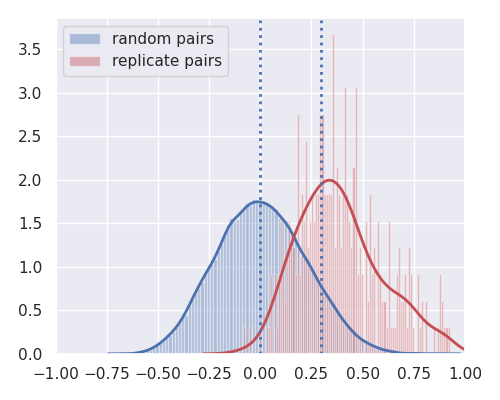

In [181]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelTA2 = standardize_per_catX(repLevelTA2,'Metadata_Plate',cp_features.tolist());
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'cp-taorf')

#### Check Replicate Correlation

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_ER', 'Cells_Correlation_Costes_DNA_Mito', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_ER_AGP', 'Cells_Correlation_Manders_ER_Mito', 'Cells_Correlation_Manders_R

<IPython.core.display.Javascript object>


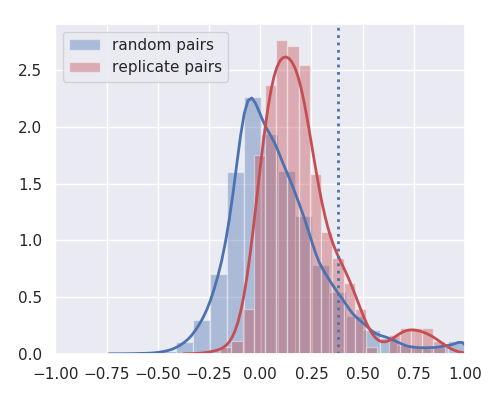

In [26]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()

cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'cp-taorf')

In [146]:
# repLevelTA2['Metadata_pert_name'].unique().shape

In [145]:
# repLevelTA2[~repLevelTA2['Metadata_Treatment'].isnull()]

In [41]:
# metaTA2
# repLevelTA2.Metadata_broad_sample.unique()


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,Metadata_Treatment,Metadata_moa,Gene Allele Name
2,41757,a03,41757,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,0.087757,0.134254,0.175410,0.164607,-0.003308,-0.022142,-0.004267,ATF4_WT.1,ER Stress/UPR,ATF4_WT.1
3,41757,a04,41757,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,0.074576,0.198571,0.337069,0.267433,0.098321,0.171637,0.146302,TSC2_WT,TOR,TSC2_WT
4,41757,a05,41757,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,0.426503,0.331142,0.493209,0.476443,-0.204066,-0.087844,-0.080835,BAX_WT,Apoptosis,BAX_WT
5,41757,a06,41757,TAORF_REFERENCE_SET,a06,VEGFC,VEGFC_WT.1,ccsbBroad304_07127,U2OS,Treated,...,0.164220,0.152590,0.189038,0.128034,-0.037912,0.044105,0.057332,VEGFC_WT.1,Hypoxia,VEGFC_WT.1
6,41757,a07,41757,TAORF_REFERENCE_SET,a07,CCND1,CCND1_WT.1,ccsbBroad304_00155,U2OS,Treated,...,0.190452,0.109554,0.212599,0.172789,-0.028852,0.085257,0.051551,CCND1_WT.1,Cell Cycle,CCND1_WT.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,41754,p12,41754,TAORF_REFERENCE_SET,p12,AKT2,AKT2_WT,ccsbBroad304_00047,U2OS,Treated,...,0.154834,0.072012,0.128960,0.126100,0.165125,0.157068,0.161339,AKT2_WT,NaN,NaN
1908,41754,p13,41754,TAORF_REFERENCE_SET,p13,XBP1,XBP1_S,BRDN0000464974,U2OS,Treated,...,0.150405,0.063452,0.130246,0.102279,0.007365,0.042932,0.040546,XBP1_S,NaN,NaN
1909,41754,p14,41754,TAORF_REFERENCE_SET,p14,RHOA,RHOA_WT,ccsbBroad304_00100,U2OS,Treated,...,0.232021,0.248644,0.271816,0.244374,0.081614,0.212082,0.189489,RHOA_WT,Cytoskeletal Re-org,RHOA_WT
1910,41754,p15,41754,TAORF_REFERENCE_SET,p15,RHOA,RHOA_T19N,BRDN0000464975,U2OS,Treated,...,0.197588,0.121507,0.160076,0.158204,0.052668,0.022378,0.044882,RHOA_T19N,NaN,NaN


In [143]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)

In [139]:
len(set(repLevelTA2['Metadata_broad_sample'])-set(taorf_l1k_df2['pert_id']))

175

In [83]:
repLevelTA2['Metadata_Treatment'].unique().shape

(324,)

In [169]:
ls ~/workspace_rosetta/workspace/preprocessed_data/

CDRPBIO-BBBC036-Bray/  LUAD-BBBC041-Caicedo/  TA-ORF-BBBC037-Rohban/


In [7]:
# np.sort(metaTA2['Metadata_Treatment'].unique())
repLevelTA2.head()

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_DifferenceVariance_ER_10_0,Nuclei_Texture_DifferenceVariance_RNA_3_0,Nuclei_Texture_Gabor_RNA_5,Nuclei_Texture_InfoMeas1_AGP_3_0,Nuclei_Texture_InfoMeas1_ER_3_0,Nuclei_Texture_InverseDifferenceMoment_DNA_10_0,Nuclei_Texture_Variance_ER_10_0,Metadata_moa,Allele,Metadata_broad_sample_2
0,41757,a01,41757,TAORF_REFERENCE_SET,a01,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,0.183206,-0.856756,-0.862536,-0.461538,-0.447009,-0.146888,0.324970,NaN,NaN,NaN
1,41757,a02,41757,TAORF_REFERENCE_SET,a02,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,0.155044,-0.495609,-0.523758,-0.270407,-0.217454,0.063475,0.179015,NaN,NaN,NaN
2,41757,a03,41757,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,0.038611,-0.173200,-0.288950,-0.015038,0.203154,0.118011,0.079778,ER Stress/UPR,ATF4_WT.1,ccsbBroad304_00117
3,41757,a04,41757,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,0.103447,-0.166625,-0.287975,-0.188032,-0.203401,0.091849,0.041468,TOR,TSC2_WT,ccsbBroad304_07101
4,41757,a05,41757,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,0.344871,-0.158059,-0.165045,-0.089917,0.017127,0.080408,0.342911,Apoptosis,BAX_WT,ccsbBroad304_00150


In [177]:
# set(metaTA1['Gene Allele Name'].unique())-set(metaTA2['Metadata_Treatment'].unique())

In [10]:
# repLevelTA2.head()
# metaTA2

In [175]:
# Y1

In [150]:
metaTA

,Metadata_broad_sample,Metadata_Treatment,Metadata_moa,Gene Allele Name
0,ccsbBroad304_00117,ATF4_WT.1,ER Stress/UPR,ATF4_WT.1
1,ccsbBroad304_07101,TSC2_WT,TOR,TSC2_WT
2,ccsbBroad304_00150,BAX_WT,Apoptosis,BAX_WT
3,ccsbBroad304_07127,VEGFC_WT.1,Hypoxia,VEGFC_WT.1
4,ccsbBroad304_00155,CCND1_WT.1,Cell Cycle,CCND1_WT.1
...,...,...,...,...
318,ccsbBroad304_00047,AKT2_WT,NaN,NaN
319,BRDN0000464974,XBP1_S,NaN,NaN
320,ccsbBroad304_00100,RHOA_WT,Cytoskeletal Re-org,RHOA_WT
321,BRDN0000464975,RHOA_T19N,NaN,NaN


In [156]:
x=pd.read_csv('~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/CellPainting/replicate_level_cp_normalized_variable_selected.csv')

In [157]:
x2=x[~x['Metadata_broad_sample'].isnull()]

In [158]:
x2.head()

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_DifferenceVariance_ER_10_0,Nuclei_Texture_DifferenceVariance_RNA_3_0,Nuclei_Texture_Gabor_RNA_5,Nuclei_Texture_InfoMeas1_AGP_3_0,Nuclei_Texture_InfoMeas1_ER_3_0,Nuclei_Texture_InverseDifferenceMoment_DNA_10_0,Nuclei_Texture_Variance_ER_10_0,Metadata_Treatment,Metadata_moa,Gene Allele Name
2,41757,a03,41757,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,0.038611,-0.173200,-0.288950,-0.015038,0.203154,0.118011,0.079778,ATF4_WT.1,ER Stress/UPR,ATF4_WT.1
3,41757,a04,41757,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,0.103447,-0.166625,-0.287975,-0.188032,-0.203401,0.091849,0.041468,TSC2_WT,TOR,TSC2_WT
4,41757,a05,41757,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,0.344871,-0.158059,-0.165045,-0.089917,0.017127,0.080408,0.342911,BAX_WT,Apoptosis,BAX_WT
5,41757,a06,41757,TAORF_REFERENCE_SET,a06,VEGFC,VEGFC_WT.1,ccsbBroad304_07127,U2OS,Treated,...,0.134264,-0.026014,-0.261035,-0.090864,-0.027993,0.051024,0.132025,VEGFC_WT.1,Hypoxia,VEGFC_WT.1
6,41757,a07,41757,TAORF_REFERENCE_SET,a07,CCND1,CCND1_WT.1,ccsbBroad304_00155,U2OS,Treated,...,0.188731,0.104063,0.066928,-0.093142,-0.087166,-0.175200,0.100237,CCND1_WT.1,Cell Cycle,CCND1_WT.1


In [159]:
x2['Metadata_moa']

2             ER Stress/UPR
3                       TOR
4                 Apoptosis
5                   Hypoxia
6                Cell Cycle
               ...         
1907                    NaN
1908                    NaN
1909    Cytoskeletal Re-org
1910                    NaN
1911       Circadian Rhythm
Name: Metadata_moa, Length: 1625, dtype: object

In [126]:
x2.groupby(['Metadata_broad_sample']).size().describe()#.describe()

count    323.000000
mean       5.030960
std        0.392833
min        5.000000
25%        5.000000
50%        5.000000
75%        5.000000
max       10.000000
dtype: float64

In [17]:
x['Allele'].unique().shape

(206,)

In [125]:
x.shape,x2.shape

((1920, 1802), (1625, 1802))

In [63]:
x['Metadata_Treatment']

0             NaN
1             NaN
2       ATF4_WT.1
3         TSC2_WT
4          BAX_WT
          ...    
1915          NaN
1916          NaN
1917          NaN
1918          NaN
1919          NaN
Name: Metadata_Treatment, Length: 1920, dtype: object

In [62]:
metadata=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/CP_LINCS/metadata/matadata_lincs.csv")
metadata[metadata["pert_iname"]=='fluvoxamine']

,broad_sample,broad_id,plate_map_name,solvent,Assay_Plate_Barcode,Batch_Number,Batch_Date,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase,alternative_moa,alternative_target
6565,BRD-K53517854-051-01-4,BRD-K53517854,C-7161-01-LM6-016,DMSO,SQ00015200,1,2016-03-22,fluvoxamine,CJOFXWAVKWHTFT,selective serotonin reuptake inhibitor (SSRI),SLC6A4,broad_id_20170327,Launched,NaN,NaN
6566,BRD-K53517854-051-01-4,BRD-K53517854,C-7161-01-LM6-016,DMSO,SQ00015138,5,2016-05-30,fluvoxamine,CJOFXWAVKWHTFT,selective serotonin reuptake inhibitor (SSRI),SLC6A4,broad_id_20170327,Launched,NaN,NaN
6567,BRD-K53517854-051-01-4,BRD-K53517854,C-7161-01-LM6-016,DMSO,SQ00015139,5,2016-05-30,fluvoxamine,CJOFXWAVKWHTFT,selective serotonin reuptake inhibitor (SSRI),SLC6A4,broad_id_20170327,Launched,NaN,NaN
6568,BRD-K53517854-051-01-4,BRD-K53517854,C-7161-01-LM6-016,DMSO,SQ00015140,5,2016-05-30,fluvoxamine,CJOFXWAVKWHTFT,selective serotonin reuptake inhibitor (SSRI),SLC6A4,broad_id_20170327,Launched,NaN,NaN
6569,BRD-K53517854-051-01-4,BRD-K53517854,C-7161-01-LM6-016,DMSO,SQ00015141,5,2016-05-30,fluvoxamine,CJOFXWAVKWHTFT,selective serotonin reuptake inhibitor (SSRI),SLC6A4,broad_id_20170327,Launched,NaN,NaN


#### CP - LINCS

In [3]:
# Ran the following on:
# https://ec2-54-242-99-61.compute-1.amazonaws.com:5006/notebooks/workspace_nucleolar/2020_07_20_Nucleolar_Calico/1-NucleolarSizeMetrics.ipynb
# Metadata
metadata=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/CP_LINCS/metadata/matadata_lincs.csv")

# saveRosDir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/preprocessed_data/LINCS-Pilot1/CellPainting'

saveRosDir='./preprocessed_data/LINCS-Pilot1/CellPainting'
profileType=['_augmented','_normalized','_normalized_dmso',\
             '_normalized_feature_select','_normalized_feature_select_dmso']
# profileType=['_normalized']
plates=metadata.Assay_Plate_Barcode.unique().tolist()
for pt in profileType[0:1]:
    repLevelLINCS0=[]
    
    for p in plates:
        profile_add=lincs_submod_root_dir+"/profiles/2016_04_01_a549_48hr_batch1/"+p+"/"+p+"_normalized_dmso.csv.gz"
        if os.path.exists(profile_add):
            repLevelLINCS0.append(pd.read_csv(profile_add))
            
    repLevelLINCS = pd.concat(repLevelLINCS0)
    meta_lincs1=metadata.rename(columns={"broad_sample": "Metadata_broad_sample"})
    # metaCDRP1=metaCDRP1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    # metaCDRP1['Metadata_Well']=metaCDRP1['Metadata_Well'].str.lower()
    
    repLevelLINCS2=pd.merge(repLevelLINCS,meta_lincs1,how='left', on=["Metadata_broad_sample"])
    

    repLevelLINCS2 = repLevelLINCS2.assign(Metadata_dose_recode=(repLevelLINCS2.Metadata_mmoles_per_liter.apply(
            lambda x: recode_dose(x, primary_dose_mapping, return_level=False))))
    repLevelLINCS2['Metadata_pert_id_dose']=repLevelLINCS2['Metadata_pert_id']+'_'+repLevelLINCS2['Metadata_dose_recode'].astype(str)
#     repLevelLINCS2['Metadata_Sample_Dose']=repLevelLINCS2['Metadata_broad_sample']+'_'+repLevelLINCS2['Metadata_dose_recode'].astype(str)
    repLevelLINCS2['Metadata_pert_id_dose']=repLevelLINCS2['Metadata_pert_id_dose'].replace(np.nan, 'DMSO')
#     repLevelLINCS2.to_csv(saveRosDir+'/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    saveDF_to_CSV_GZ_no_timestamp(repLevelLINCS2,saveRosDir+'/replicate_level_cp'+pt+'.csv.gz')
    print(meta_lincs1.shape,repLevelLINCS.shape,repLevelLINCS2.shape)

NameError: name 'lincs_submod_root_dir' is not defined

In [3]:
os.listdir('./preprocessed_data/'+d1+'/'+d2)

NameError: name 'd1' is not defined

In [42]:
datasets=['LINCS-Pilot1']
# ,'LUAD-BBBC041-Caicedo', 'TA-ORF-BBBC037-Rohban','LINCS-pilot1','CDRPBIO-BBBC036-Bray'
dataType=['CellPainting']#, 'L1000']
for d1 in datasets:
    for d2 in dataType:
        csv_files=os.listdir('./preprocessed_data/'+d1+'/'+d2)
        for cf in csv_files[2:5]:
            print(cf)
            csv_pddf=pd.read_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf)
            csv_pddf = csv_pddf.assign(Metadata_dose_recode=(csv_pddf.Metadata_mmoles_per_liter.apply(
            lambda x: recode_dose(x, primary_dose_mapping, return_level=False))))
      
            csv_pddf['Metadata_pert_id_dose']=csv_pddf['Metadata_pert_id']+'_'+csv_pddf['Metadata_dose_recode'].astype(str)
            
#             os.system('rm '+'./preprocessed_data/'+d1+'/'+d2+'/'+cf)
            csv_pddf.to_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf,index=False,compression='gzip')


replicate_level_cp_normalized_dmso.csv.gz
.ipynb_checkpoints
replicate_level_cp_augmented.csv.gz
replicate_level_cp_normalized_feature_select_dmso.csv.gz
replicate_level_cp_normalized_feature_select.csv.gz
replicate_level_cp_normalized.csv.gz


In [93]:
# csv_pddf.groupby('Metadata_Sample_Dose').size().describe()

In [108]:
csv_l1k_lincs.columns[csv_l1k_lincs.columns.str.contains('pert')]

Index(['pert_dose', 'pert_dose_unit', 'pert_id', 'pert_id_vendor',
       'pert_idose', 'pert_iname_x', 'pert_itime', 'pert_mfc_desc',
       'pert_mfc_id', 'pert_time', 'pert_time_unit', 'pert_type_x',
       'pert_vehicle', 'pert_plate', 'pert_iname_y', 'pert_type_y',
       'pert_id_dose'],
      dtype='object')

In [109]:
csv_pddf.columns[csv_pddf.columns.str.contains('pert')]

Index(['Metadata_pert_id', 'Metadata_pert_mfc_id', 'Metadata_pert_well',
       'Metadata_pert_id_vendor', 'Metadata_pert_vehicle',
       'Metadata_pert_type', 'pert_iname'],
      dtype='object')

In [100]:
csv_l1k_lincs=pd.read_csv('./preprocessed_data/LINCS-Pilot1/L1000/replicate_level_l1k'+'.csv.gz')
csv_pddf=pd.read_csv('./preprocessed_data/LINCS-Pilot1/CellPainting/replicate_level_cp'+pt[0]+'.csv.gz')

In [101]:
csv_l1k_lincs.head()

,cid,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,...,nearest_dose,brew_prefix,group_id,nsig,cc_q75,tas_q75,pert_iname_y,pert_type_y,moa,pert_id_dose
0,REP.A001_A549_24H_X1_B27:A03,0.3547,-0.4940,-0.1721,-0.0339,-0.4355,1.8263,-0.1316,0.0853,-0.4660,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A03,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
1,REP.A001_A549_24H_X1_B27:A04,-0.2130,0.4931,-0.8768,-0.6968,-1.7018,-0.3779,-0.6745,-1.9799,-1.1429,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A04,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
2,REP.A001_A549_24H_X1_B27:A05,-0.3280,-0.4555,0.3819,-1.1447,0.0951,-0.5498,-0.6745,-0.0950,-0.2946,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A05,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
3,REP.A001_A549_24H_X1_B27:A06,0.1175,-0.9678,-0.3185,0.4623,-0.2842,-0.9202,-0.8413,0.7160,0.3384,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A06,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
4,REP.A001_A549_24H_X1_B27:A07,0.5254,0.0000,-0.4691,0.3652,-1.0688,0.0793,-1.1123,0.1908,-0.8249,...,10.0,REP.A001_A549_24H,REP.A001_A549_24H:A07,6,0.085,0.086878,aminoguanidine,trt_cp,Nitric oxide synthase inhibitor,BRD-K25114078_10


In [121]:
csv_pddf.head()

,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_pert_id_vendor,Metadata_cell_id,...,InChIKey14,moa,target,broad_date,clinical_phase,alternative_moa,alternative_target,Metadata_dose_recode,Metadata_Sample_Dose,Metadata_pert_id_dose
0,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A01,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,DMSO_0.04,NaN
1,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A02,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,DMSO_0.04,NaN
2,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A03,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,DMSO_0.04,NaN
3,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A04,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,DMSO_0.04,NaN
4,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A05,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,DMSO_0.04,NaN


In [104]:
csv_l1k_lincs.pert_id_dose.unique()

array(['DMSO_-666', 'BRD-K25114078_10', 'BRD-K25114078_3.33', ...,
       'BRD-A97502381_0.12', 'BRD-A97502381_0.04', 'BRD-A95696066_10'],
      dtype=object)

In [120]:
csv_pddf.Metadata_pert_id_dose.unique()

array([nan, 'BRD-A62035778_10.0', 'BRD-A62035778_3.33', ...,
       'BRD-K61567297_0.37', 'BRD-K61567297_0.12', 'BRD-K61567297_0.04'],
      dtype=object)

#### Read saved data

In [203]:
pt=['_normalized_dmso']
# Read save data
repLevelLincs2=pd.read_csv('./preprocessed_data/LINCS-Pilot1/CellPainting/replicate_level_cp'+pt[0]+'.csv.gz')

# csv_pddf = csv_pddf.assign(Metadata_dose_recode=(csv_pddf.Metadata_mmoles_per_liter.apply(
#             lambda x: recode_dose(x, primary_dose_mapping, return_level=False))))
# csv_pddf['Metadata_Sample_Dose']=csv_pddf['Metadata_broad_sample']+'_'+csv_pddf['Metadata_dose_recode'].astype(str)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19,1820,1821) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
def recode_dose(x, doses, return_level=False):
    closest_index = np.argmin([np.abs(dose - x) for dose in doses])
    if np.isnan(x):
        return 0
    if return_level:
        return closest_index + 1
    else:
        return doses[closest_index]
    
primary_dose_mapping = [0.04, 0.12, 0.37, 1.11, 3.33, 10, 20]

In [216]:
repLevelLincs2.groupby(['Metadata_pert_id']).size()

Metadata_pert_id
BRD-A00147595    24
BRD-A00218260    24
BRD-A00376169    24
BRD-A00546892    24
BRD-A00938334    24
                 ..
BRD-K99964838    30
BRD-M39350793    12
BRD-M80207679    30
BRD-M89827113    30
BRD-M98279124    30
Length: 1570, dtype: int64

In [207]:
repLevelLincs2.groupby(['Metadata_pert_id_dose']).size().describe()

count    9395.000000
mean        5.558595
std        41.161990
min         2.000000
25%         5.000000
50%         5.000000
75%         5.000000
max      3264.000000
dtype: float64

In [212]:
repLevelLincs2.Metadata_Plate.unique().shape

(136,)

In [214]:
repLevelLincs2['Metadata_pert_id_dose'].unique().shape

(9395,)

In [129]:
# csv_pddf['Metadata_mmoles_per_liter'].round(0).unique()
# np.sort(csv_pddf['Metadata_mmoles_per_liter'].unique())

In [141]:
csv_pddf.groupby(['Metadata_dose_recode']).size()#.median()

Metadata_dose_recode
0.04     10954
0.12      7616
0.37      7616
1.11      7616
3.33      7589
10.00     7568
20.00     3264
dtype: int64

['Cells_RadialDistribution_FracAtD_DNA_1of4', 'Cells_RadialDistribution_FracAtD_DNA_2of4', 'Cells_RadialDistribution_FracAtD_DNA_3of4', 'Cells_RadialDistribution_FracAtD_DNA_4of4', 'Cells_RadialDistribution_MeanFrac_DNA_1of4', 'Cells_RadialDistribution_MeanFrac_DNA_2of4', 'Cells_RadialDistribution_MeanFrac_DNA_3of4', 'Cells_RadialDistribution_MeanFrac_DNA_4of4', 'Cells_RadialDistribution_RadialCV_DNA_1of4', 'Cells_RadialDistribution_RadialCV_DNA_2of4', 'Cells_RadialDistribution_RadialCV_DNA_3of4', 'Cells_RadialDistribution_RadialCV_DNA_4of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_1of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_2of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_3of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_4of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_1of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_3of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4', 'Cytoplasm_RadialDistribution_RadialCV_DNA_1of4', 'Cyto

<IPython.core.display.Javascript object>


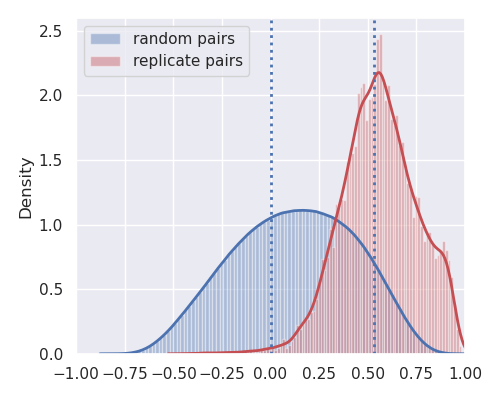

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [8]:
# repLevelLincs2=csv_pddf.copy()
import gc
cp_features=repLevelLincs2.columns[repLevelLincs2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLincs2[i].isnull()).sum(axis=0)/repLevelLincs2.shape[0])>0.05]
print(cols2remove0)
repLevelLincs3=repLevelLincs2.drop(cols2remove0, axis=1);
print('here0')
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
del repLevelLincs2
gc.collect()
print('here0')
cp_features=repLevelLincs3.columns[repLevelLincs3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelLincs3[cp_features] = repLevelLincs3[cp_features].interpolate()
print('here1')
repLevelLincs3 = standardize_per_catX(repLevelLincs3,'Metadata_Plate',cp_features.tolist());
print('here1')

# df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# repSizeDF=repLevelLincs3.groupby(['Metadata_broad_sample']).size().reset_index()
repSizeDF=repLevelLincs3.groupby(['Metadata_pert_id_dose']).size().reset_index()

highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_pert_id_dose.tolist()
highRepComp.remove('DMSO')
# df0=repLevelLincs3[(repLevelLincs3['Metadata_broad_sample'].isin(highRepComp)) &\
#                    (repLevelLincs3['Metadata_dose_recode']==1.11)]
df0=repLevelLincs3[(repLevelLincs3['Metadata_pert_id_dose'].isin(highRepComp))]
x_lincs_cp=replicateCorrs(df0,'Metadata_pert_id_dose',cp_features,1)
# saveAsNewSheetToExistingFile(filename,x_lincs_cp[2],'cp-lincs')

In [5]:
repSizeDF

,Metadata_pert_id_dose,0
0,BRD-A00147595_0.04,4
1,BRD-A00147595_0.12,4
2,BRD-A00147595_0.37,4
3,BRD-A00147595_1.11,4
4,BRD-A00147595_10.0,4
...,...,...
9390,BRD-M98279124_0.37,5
9391,BRD-M98279124_1.11,5
9392,BRD-M98279124_10.0,5
9393,BRD-M98279124_3.33,5


here2


<IPython.core.display.Javascript object>


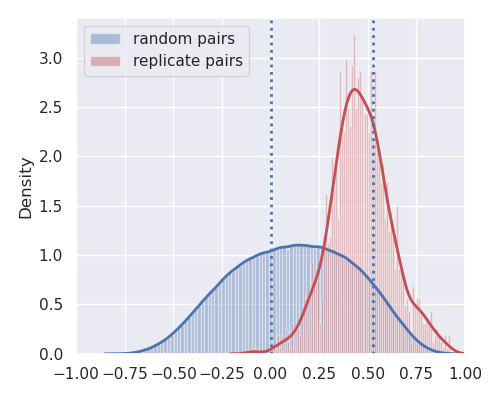

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [18]:
# repLevelLincs2=csv_pddf.copy()

# cp_features=repLevelLincs2.columns[repLevelLincs2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# cols2remove0=[i for i in cp_features if ((repLevelLincs2[i].isnull()).sum(axis=0)/repLevelLincs2.shape[0])>0.05]
# print(cols2remove0)
# repLevelLincs3=repLevelLincs2.drop(cols2remove0, axis=1);
# # cp_features=list(set(cp_features)-set(cols2remove0))
# # repLevelTA2=repLevelTA2.replace('nan', np.nan)
# repLevelLincs3 = repLevelLincs3.interpolate()

# repLevelLincs3 = standardize_per_catX(repLevelLincs3,'Metadata_Plate',cp_features.tolist());

# cp_features=repLevelLincs3.columns[repLevelLincs3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# # df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# # repSizeDF=repLevelLincs3.groupby(['Metadata_broad_sample']).size().reset_index()
repSizeDF=repLevelLincs3.groupby(['Metadata_pert_id']).size().reset_index()

highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_pert_id.tolist()
# highRepComp.remove('DMSO')
# df0=repLevelLincs3[(repLevelLincs3['Metadata_broad_sample'].isin(highRepComp)) &\
#                    (repLevelLincs3['Metadata_dose_recode']==1.11)]
df0=repLevelLincs3[(repLevelLincs3['Metadata_pert_id'].isin(highRepComp))]
x_lincs_cp=replicateCorrs(df0,'Metadata_pert_id',cp_features,1)
# saveAsNewSheetToExistingFile(filename,x_lincs_cp[2],'cp-lincs')

In [17]:
# x=replicateCorrs(df0,'Metadata_broad_sample',cp_features,1)
# highRepComp[-1]


In [140]:
saveAsNewSheetToExistingFile(filename,x[2],'cp-lincs')

In [168]:
# repLevelLincs3.Metadata_Plate
repLevelLincs3.head()

,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_pert_id_vendor,Metadata_cell_id,...,Batch_Date,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase,alternative_moa,alternative_target,Metadata_dose_recode
0,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A01,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
1,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A02,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
2,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A03,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
3,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A04,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
4,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A05,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04


In [127]:
# csv_pddf[(csv_pddf['Metadata_dose_recode']==0.04) & (csv_pddf['Metadata_pert_id']=="BRD-A00147595")][['Metadata_Plate','Metadata_Well']].drop_duplicates()

In [126]:
# csv_pddf[(csv_pddf['Metadata_dose_recode']==0.04) & (csv_pddf['Metadata_pert_id']=="BRD-A00147595") &
#         (csv_pddf['Metadata_Plate']=='SQ00015196') & (csv_pddf['Metadata_Well']=="B12")][csv_pddf.columns[1820:]].drop_duplicates()

In [160]:
column_name='Metadata_Plate'
cp_features.tolist()+[column_name]

['Cells_AreaShape_Area',
 'Cells_AreaShape_Center_X',
 'Cells_AreaShape_Center_Y',
 'Cells_AreaShape_Compactness',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_EulerNumber',
 'Cells_AreaShape_Extent',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_MajorAxisLength',
 'Cells_AreaShape_MaxFeretDiameter',
 'Cells_AreaShape_MaximumRadius',
 'Cells_AreaShape_MeanRadius',
 'Cells_AreaShape_MedianRadius',
 'Cells_AreaShape_MinFeretDiameter',
 'Cells_AreaShape_MinorAxisLength',
 'Cells_AreaShape_Orientation',
 'Cells_AreaShape_Perimeter',
 'Cells_AreaShape_Solidity',
 'Cells_AreaShape_Zernike_0_0',
 'Cells_AreaShape_Zernike_1_1',
 'Cells_AreaShape_Zernike_2_0',
 'Cells_AreaShape_Zernike_2_2',
 'Cells_AreaShape_Zernike_3_1',
 'Cells_AreaShape_Zernike_3_3',
 'Cells_AreaShape_Zernike_4_0',
 'Cells_AreaShape_Zernike_4_2',
 'Cells_AreaShape_Zernike_4_4',
 'Cells_AreaShape_Zernike_5_1',
 'Cells_AreaShape_Zernike_5_3',
 'Cells_AreaShape_Zernike_5_5',
 'Cells_AreaShape_Zernike_6_0',
 'Cells_Are

In [162]:
# def standardize_per_catX(df,column_name):
column_name='Metadata_Plate'
repLevelLincs_scaled_perPlate=repLevelLincs3.copy()
repLevelLincs_scaled_perPlate[cp_features.tolist()]=repLevelLincs3[cp_features.tolist()+[column_name]].groupby(column_name).transform(lambda x: (x - x.mean()) / x.std()).values

In [ ]:
# def standardize_per_catX(df,column_name):
# # column_name='Metadata_Plate'
#     cp_features=df.columns[df.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
#     df_scaled_perPlate=df.copy()
#     df_scaled_perPlate[cp_features.tolist()]=\
#     df[cp_features.tolist()+[column_name]].groupby(column_name)\
#     .transform(lambda x: (x - x.mean()) / x.std()).values
#     return df_scaled_perPlate

<IPython.core.display.Javascript object>


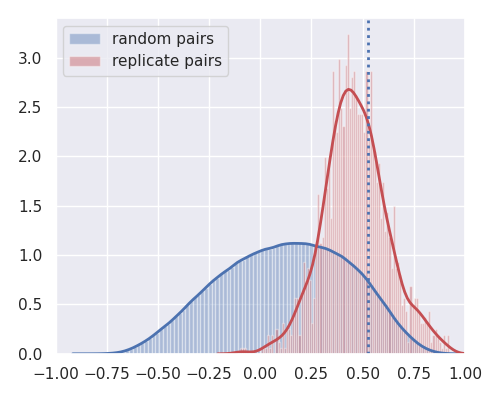

In [163]:
df0=repLevelLincs_scaled_perPlate[(repLevelLincs_scaled_perPlate['Metadata_Sample_Dose'].isin(highRepComp))]
x=replicateCorrs(df0,'Metadata_broad_sample',cp_features,1)

#### Change csv files to csv.gz format

In [11]:
os.listdir('./preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting')

['replicate_level_cp_normalized_variable_selected.csv',
 'replicate_corr_DF__normalized.csv',
 'replicate_level_cp_augmented.csv',
 'replicate_level_cp_normalized.csv']

In [18]:
# datasets=['LINCS-pilot1']
datasets=['LUAD-BBBC041-Caicedo', 'TA-ORF-BBBC037-Rohban','LINCS-pilot1','CDRPBIO-BBBC036-Bray']
dataType=['CellPainting', 'L1000']
for d1 in datasets:
    for d2 in dataType:
        csv_files=os.listdir('./preprocessed_data/'+d1+'/'+d2)
        for cf in csv_files:
            print(cf)
            csv_pddf=pd.read_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf)
            os.system('rm '+'./preprocessed_data/'+d1+'/'+d2+'/'+cf)
            csv_pddf.to_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf,index=False,compression=compression_opts)          

In [ ]:
Remove time stamps from all csv.gz files

In [30]:
from gzip import GzipFile
from io import TextIOWrapper

datasets=['LINCS-Pilot1','CDRPBIO-BBBC036-Bray']
dataType=['CellPainting', 'L1000']
for d1 in datasets:
    for d2 in dataType:
        csv_files=os.listdir('./preprocessed_data/'+d1+'/'+d2)
        csv_files=[c for c in csv_files if c != ".ipynb_checkpoints"]
        for cf in csv_files:
            print(cf)
            cf_full='./preprocessed_data/'+d1+'/'+d2+'/'+cf
            csv_pddf=pd.read_csv(cf_full)
#             os.system('rm '+cf_full)
#             csv_pddf.to_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf,index=False,compression=compression_opts)    

            with TextIOWrapper(GzipFile(cf_full, 'w', mtime=0), encoding='utf-8') as fd:
                csv_pddf.to_csv(fd,index=False,compression='gzip')
#             saveDF_to_CSV_GZ_no_timestamp(csv_pddf,cf_full)
# to_gzip_csv_no_timestamp(df, 'df.csv.gz')
# to_gzip_csv_no_timestamp(df, 'df2.csv.gz')

# filecmp.cmp('df.csv.gz', 'df2.csv.gz')

replicate_level_cp_normalized_dmso.csv.gz


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19,1820,1821) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


replicate_level_cp_augmented.csv.gz
replicate_level_cp_normalized_feature_select_dmso.csv.gz


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19,1249,1250) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


replicate_level_cp_normalized_feature_select.csv.gz
replicate_level_cp_normalized.csv.gz
level_5_rank.csv.gz
level_5_modz.csv.gz
level_3.csv.gz
level_4.csv.gz
level_4W.csv.gz
replicate_level_l1k.csv.gz
replicate_level_cp_augmented.csv.gz


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1800,1801,1802,1803) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


replicate_corr_DF__normalized.csv.gz
replicate_level_cp_normalized_variable_selected.csv.gz
replicate_level_cp_normalized.csv.gz
replicate_level_l1k_vczscore.csv.gz
treatment_level_l1k.csv.gz
replicate_level_l1k_pclfc.csv.gz
replicate_level_l1k_pczscore.csv.gz
replicate_level_l1k.csv.gz


In [ ]:
def saveDF_to_CSV_GZ_no_timestamp(df,filename):
    with TextIOWrapper(GzipFile(cf_full, 'w', mtime=0), encoding='utf-8') as fd:
        csv_pddf.to_csv(fd,index=False,compression='gzip')
    return

In [29]:
ls ./preprocessed_data/

CDRPBIO-BBBC036-Bray/  LUAD-BBBC041-Caicedo/
LINCS-Pilot1/          TA-ORF-BBBC037-Rohban/


In [23]:
# compression_opts
replicate_level_l1k-test.csv.gz
2 days ago1.99 MB
replicate_level_l1k.csv.gz
an hour ago1.97 MB
replicate_level_l1k_QNORM.csv.gz
2 days ago1.8 MB
replicate_level_l1k_ZSPCQNORM.csv.gz
2 days ago2.02 MB

'./preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp.csv.gz'

In [17]:
csv_pddf.to_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf,index=False,compression=compression_opts)

In [ ]:
.
├── preprocessed_data
│   ├── CDRPBIO-BBBC036-Bray
│   │   ├── CellPainting
│   │   ├── L1000
│   │   └── metadata
│   ├── LUAD-BBBC041-Caicedo
│   │   ├── CellPainting
│   │   ├── L1000
│   │   └── metadata
│   └── TA-ORF-BBBC037-Rohban
│       ├── CellPainting
│       ├── L1000
│       └── metadata
├── raw_profiles
│   ├── CP_CDRP
│   │   └── metadata
│   ├── CP_LUAD
│   │   └── metadata
│   ├── CP_TA_ORF
│   │   └── metadata
│   ├── l1000_CDRP
│   │   ├── Broad.PNAS2014.ProfilingData

│   │   ├── cdrp.cpd.prof.mat
│   │   ├── cdrp.well.metadata.mat
│   │   ├── cdrp.well.pczscore.mat
│   │   ├── cdrp.well.prof.mat
│   │   ├── compounds.txt
│   │   ├── ge.profiles_n21983x977.gct
│   │   ├── ge.profiles_n21983x977.gctx
│   │   ├── hts.hitcounts.txt
│   │   ├── mc.profiles_n30439x812.gct
│   │   ├── mc.profiles_n30439x812.gctx
│   │   ├── readme.txt
│   │   └── wawer.gene.all.prof.rds
│   ├── l1000_LUAD
│   │   ├── input
│   │   └── output
│   └── l1000_TA_ORF
│       ├── ignored_plates_d2.grp.txt
│       ├── Index of _icmap_custom_TA_brew_pc_TA.OE005_U2OS_72H_files
│       ├── Index of _icmap_custom_TA_brew_pc_TA.OE005_U2OS_72H.html
│       ├── plates_d2.grp.txt
│       ├── README
│       ├── splice_pipe_params.txt
│       ├── TA.OE005_U2OS_72H_by_pert_id_pert_dose_files
│       ├── TA.OE005_U2OS_72H_by_pert_id_pert_dose.html
│       ├── TA.OE005_U2OS_72H_by_rna_well_files
│       ├── TA.OE005_U2OS_72H_by_rna_well.html
│       ├── TA.OE005_U2OS_72H_INF_n729x22268.gctx
│       ├── TA.OE005_U2OS_72H.map.txt
│       ├── TA.OE005_U2OS_72H_QNORM_n729x978.gctx
│       ├── TA.OE005_U2OS_72H_ZSPCINF_n729x22268.gctx
│       └── TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx

In [ ]:
root_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
meta=pd.read_csv(root_dir+'/metadata/affy_probe_gene_mapping.txt',delimiter="\t",header=None, names=["probe_id", "gene"])
meta_gene_probID=meta.set_index('probe_id')
meta_gene_probID.head()


## Correlation between protein abundance and expression levels
* Read the expression levels for 29 tissues and calculate correlation coeffs between protein abundance and gene expression
* Save the cc for each gene in another csv file /metadata/proteome-transcriptome-abundance/Table_EV2_corrs.csv

In [ ]:
Table_EV2=pd.read_excel(root_dir+'/metadata/proteome-transcriptome-abundance/Table_EV2.xlsx', sheet_name=None)
A_transcripts=Table_EV2['A. Transcripts']
B_genes=Table_EV2['B. Genes']
tissues29=A_transcripts.columns[4:].tolist()
genes_uniq=B_genes['Gene name'].unique().tolist()
prot_gen_cor=pd.DataFrame(index=genes_uniq,columns=['corr1'])
for gene in genes_uniq:
    ge_vec=B_genes[B_genes['Gene name']==gene][tissues29].sample(1).values
    tr_vec_df=A_transcripts[A_transcripts['Gene name']==gene][tissues29].reset_index(drop=True)
    cc_val=[]
    for t in range(tr_vec_df.shape[0]):
        tr_vec=tr_vec_df.loc[t,:].values
        cc_val.append(scipy.stats.pearsonr(np.squeeze(tr_vec), np.squeeze(ge_vec))[0])
        
    prot_gen_cor.loc[gene,"corr1"]=np.nanmedian(cc_val)
    
prot_gen_cor.to_csv(root_dir+'/metadata/proteome-transcriptome-abundance/Table_EV2_corrs.csv')

In [ ]:
prot_gen_cor.isnull().sum()

In [43]:
dataPath='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/results/sample_cells/results'
# rootPath='/Users/mhaghigh/work/projects/2017_09_27_RareDiseases_Taipale/workspace/'


# DATA_DIR=dataPath
imageslist=os.listdir(dataPath)

In [44]:
imageslist

['real_2-1-0-7-6-4-3-5-8-9.png',
 'real_2-6-3-4-5-9-0-7-8-1.png',
 'real_4-2-6-7-1-0-9-3-5-8.png',
 'real_4-6-8-0-3-2-9-5-1-7.png',
 'real_5-6-3-9-8-2-4-0-1-7.png',
 'real_6-2-1-5-7-4-9-0-8-3.png',
 'real_6-8-4-3-1-7-9-0-2-5.png',
 'real_6-8-9-1-2-7-4-5-0-3.png',
 'real_7-1-8-0-2-5-9-3-4-6.png',
 'real_7-6-4-3-5-8-9-2-1-0.png',
 'real_8-2-5-9-0-7-6-1-4-3.png',
 'real_8-4-7-9-0-3-5-1-2-6.png',
 'real_8-9-5-4-0-1-3-6-7-2.png',
 'real_9-2-1-6-7-5-3-8-4-0.png',
 'real_9-3-0-2-8-7-1-6-4-5.png',
 'real_9-7-0-3-5-4-8-2-6-1.png',
 'synth_0-1-6-2-9-8-4-7-5-3.png',
 'synth_0-1-9-6-2-5-7-3-8-4.png',
 'synth_0-6-7-3-4-2-8-9-1-5.png',
 'synth_1-5-9-3-8-2-0-4-7-6.png',
 'synth_2-6-4-5-3-9-0-7-1-8.png',
 'synth_3-7-8-0-1-5-6-9-2-4.png',
 'synth_4-0-6-5-8-3-1-2-7-9.png',
 'synth_6-0-2-1-7-9-5-8-3-4.png',
 'synth_7-8-6-4-9-5-0-2-1-3.png',
 'synth_8-1-9-5-6-3-0-4-7-2.png',
 'synth_8-5-0-7-4-1-6-2-9-3.png',
 'synth_8-9-2-6-3-1-0-4-7-5.png',
 'synth_9-4-5-3-8-2-7-0-1-6.png']

In [52]:
''.join(imageslist[0].split('_')[1].split('.')[0].split('-'))

'2107643589'

In [24]:
final_df=pd.DataFrame(index=range(len(imageslist)), columns=['im_list','user_inputs','true_class'])
final_df['im_list']=imageslist
final_df

,im_list,user_inputs,true_class
0,real_2-1-0-7-6-4-3-5-8-9.png,NaN,NaN
1,real_2-6-3-4-5-9-0-7-8-1.png,NaN,NaN
2,real_4-2-6-7-1-0-9-3-5-8.png,NaN,NaN
3,real_4-6-8-0-3-2-9-5-1-7.png,NaN,NaN
4,real_5-6-3-9-8-2-4-0-1-7.png,NaN,NaN
5,real_6-2-1-5-7-4-9-0-8-3.png,NaN,NaN
6,real_6-8-4-3-1-7-9-0-2-5.png,NaN,NaN
7,real_6-8-9-1-2-7-4-5-0-3.png,NaN,NaN
8,real_7-1-8-0-2-5-9-3-4-6.png,NaN,NaN
9,real_7-6-4-3-5-8-9-2-1-0.png,NaN,NaN


<IPython.core.display.Javascript object>


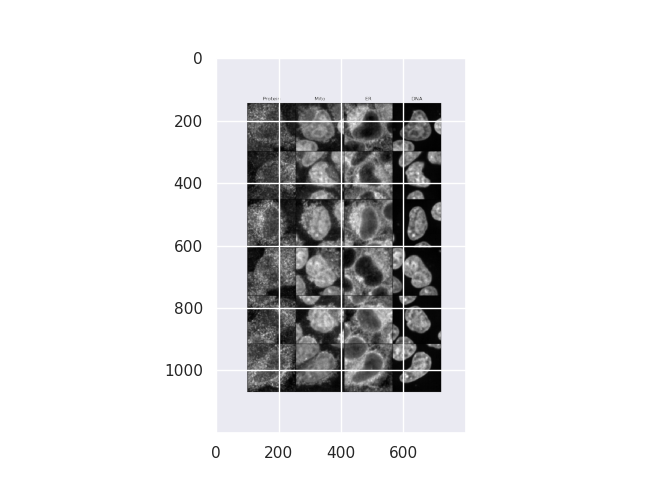

(1200, 800, 4) 255 0


In [31]:
import skimage.io
plt.figure()
img = skimage.io.imread(dataPath+'/'+imageslist[0])
print(img.shape,img.max(),img.min())
plt.imshow(img)

In [36]:
img = skimage.io.imread(dataPath+'/'+imageslist[2])
print(img.shape,img.max(),img.min())

(136, 1324, 3) 255 0


In [41]:
from PIL import Image, ImageDraw, ImageFont

img = Image.open(dataPath+'/'+imageslist[2])
# print(img.shape,img.max(),img.min())
img = img.convert('RGBA')
img = np.array(img)

In [42]:
img.shape

(136, 1324, 4)